# Sequential U-turn image experiments

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import imageio # For creating GIFs

# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete. Libraries imported.")

Setup complete. Libraries imported.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import imageio # For creating GIFs

# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete. Libraries imported.")
# --- Configuration ---

# 1. Path to the experiment you want to visualize
# BASE_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/results/sequential_uturns"
# BASE_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/results/sequential_uturns"

# BASE_RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns_debug_respaced"
BASE_RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns"

# IMAGE_NAME = "ILSVRC2012_val_00000487"

IMAGE_NAME = "ILSVRC2012_val_00010875"
IMAGE_NAME = "ILSVRC2012_val_00000729"


NOISE_STEP = 200
TRAJECTORY_INDEX = 4

# --- NEW: Set the jump/step size for visualizations ---
# JUMP_SIZE = 1 # Show every step
# JUMP_SIZE = 2 # Show steps 0, 2, 4, 6...
JUMP_SIZE = 5  # Show steps 0, 5, 10, 15...

# 3. Analysis parameters
DIFF_THRESHOLD = 13.0

# 4. GIF parameters
FPS = 15               # Slower FPS for jumped trajectory
NUM_FADE_FRAMES = 15
PAUSE_FRAMES = 5

# --- End of Configuration ---

# Construct the full path to the trajectory data
trajectory_dir = os.path.join(BASE_RESULTS_DIR, IMAGE_NAME, f"noise_step_{NOISE_STEP}", f"trajectory_{TRAJECTORY_INDEX:03d}")

# Verify that the path exists
if not os.path.isdir(trajectory_dir):
    print(f"❌ Error: Directory not found at '{trajectory_dir}'")
    print("Please check your configuration variables.")
else:
    print(f"✅ Trajectory directory found: {trajectory_dir}")



Setup complete. Libraries imported.
✅ Trajectory directory found: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_200/trajectory_004


In [3]:
# !cd /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns
# !cd /ILSVRC2012_val_00000729
# !ls

In [4]:
uturn_images = []
trajectory_embeddings = None

print("Loading trajectory data...")
try:
    # Load the embeddings from the .npz file
    npz_path = os.path.join(trajectory_dir, "trajectory_data.npz")
    data = np.load(npz_path)
    trajectory_embeddings = torch.from_numpy(data['embeddings'])
    
    # --- THIS IS THE FIX ---
    # Perform two separate glob searches and combine the lists.
    # This is the most robust way to find multiple extensions.
    jpeg_paths = sorted(glob.glob(os.path.join(trajectory_dir, "uturn_*.jpeg")))
    png_paths = sorted(glob.glob(os.path.join(trajectory_dir, "uturn_*.png")))
    image_paths = sorted(jpeg_paths + png_paths)
    # --- END OF FIX ---
    
    if not image_paths:
        raise FileNotFoundError("No 'uturn_*.jpeg' or '.png' images found.")
        
    for path in image_paths:
        uturn_images.append(Image.open(path))

    print(f"✅ Successfully loaded {len(uturn_images)} images.")
    print(f"✅ Found {trajectory_embeddings.shape[0]} embeddings in the .npz file.")
    
    # Add a check for data consistency
    if len(uturn_images) != trajectory_embeddings.shape[0]:
        print("\n⚠️ WARNING: The number of images found does not match the number of embeddings.")
        print(f"   Found {len(uturn_images)} images and {trajectory_embeddings.shape[0]} embeddings.")
        print("   This can happen if a generation job was interrupted. The analysis will proceed with the smaller of the two counts.")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please ensure your configuration is correct and the experiment finished successfully.")

Loading trajectory data...
✅ Successfully loaded 101 images.
✅ Found 101 embeddings in the .npz file.


✅ Static plot saved to: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_200/trajectory_004/static_trajectory_plot_jump5.png


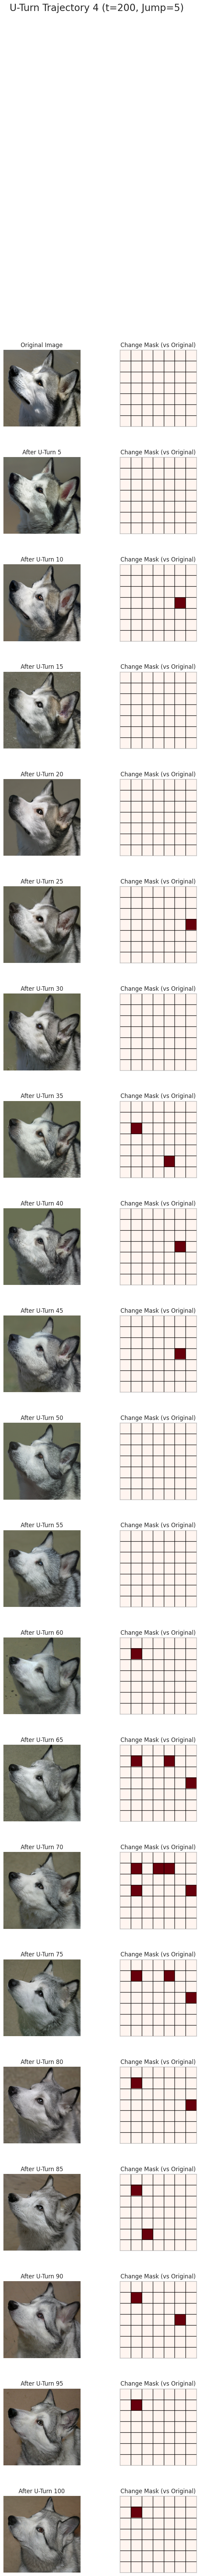

In [5]:
import matplotlib.gridspec as gridspec

if uturn_images and trajectory_embeddings is not None:
    # --- CHANGE: Create a list of indices to plot based on JUMP_SIZE ---
    # steps_to_plot = range(0, len(uturn_images), JUMP_SIZE)
    steps_to_plot = range(0, len(uturn_images), JUMP_SIZE)
    num_plot_steps = len(steps_to_plot)
    
    fig = plt.figure(figsize=(8, 4 * num_plot_steps))
    gs = gridspec.GridSpec(num_plot_steps, 2, figure=fig, hspace=0.4)
    
    fig.suptitle(f"U-Turn Trajectory {TRAJECTORY_INDEX} (t={NOISE_STEP}, Jump={JUMP_SIZE})", fontsize=20, y=1.0)
    
    original_embedding = trajectory_embeddings[0]

    # --- CHANGE: Loop over the selected plot steps ---
    for plot_idx, step_idx in enumerate(steps_to_plot):
        ax_img = fig.add_subplot(gs[plot_idx, 0])
        ax_map = fig.add_subplot(gs[plot_idx, 1])

        # --- Left Column ---
        ax_img.imshow(uturn_images[step_idx])
        title = "Original Image" if step_idx == 0 else f"After U-Turn {step_idx}"
        ax_img.set_title(title)
        ax_img.axis('off')

        # --- Right Column ---
        current_embedding = trajectory_embeddings[step_idx]
        diff_map = torch.norm(current_embedding - original_embedding, dim=-1).reshape(7, 7)
        change_mask = (diff_map > DIFF_THRESHOLD)
        
        ax_map.imshow(change_mask, cmap='Reds', vmin=0, vmax=1)
        ax_map.set_title("Change Mask (vs Original)")

    
        ax_map.set_xticks(np.arange(-.5, 7, 1), minor=True)
        ax_map.set_yticks(np.arange(-.5, 7, 1), minor=True)
        ax_map.grid(which="minor", color="black", linestyle='-', linewidth=1)
        ax_map.tick_params(which="minor", size=0)
        ax_map.set_xticks([])
        ax_map.set_yticks([])
        
    # Save the figure
    save_path = os.path.join(trajectory_dir, f"static_trajectory_plot_jump{JUMP_SIZE}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.2)
    print(f"✅ Static plot saved to: {save_path}")

    plt.show()

In [48]:
import shutil
import os
from IPython.display import FileLink, display

# 1. Define source and destination
source_path = '/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00010875/noise_step_150/trajectory_002/static_trajectory_plot_jump5.png'
local_filename = 'download_me.png' # We rename it to keep it simple

# 2. Copy the file to the current directory (where the .ipynb is running)
shutil.copy(source_path, local_filename)

print(f"Copied file to: {os.getcwd()}/{local_filename}")

# 3. Generate the link (Now it will work because the file is local)
display(FileLink(local_filename))

Copied file to: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/notebooks/download_me.png


/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/notebooks/download_me.png

In [32]:
if uturn_images:
    # --- CHANGE: Create a new list of images based on the jump size ---
    images_to_animate = [uturn_images[i] for i in range(0, len(uturn_images), JUMP_SIZE)]
    print(f"Generating animated GIF from {len(images_to_animate)} sampled frames...")
    
    frames = []

    for i in range(len(images_to_animate) - 1):
        img_start = images_to_animate[i]
        img_end = images_to_animate[i+1]
        
        for _ in range(PAUSE_FRAMES):
            frames.append(img_start)
            
        for j in range(NUM_FADE_FRAMES):
            alpha = j / (NUM_FADE_FRAMES - 1)
            blended_img = Image.blend(img_start, img_end, alpha=alpha)
            frames.append(blended_img)

    for _ in range(PAUSE_FRAMES * 2):
        frames.append(images_to_animate[-1])

    gif_path = os.path.join(trajectory_dir, f"animated_trajectory_jump{JUMP_SIZE}.gif")
    imageio.mimsave(gif_path, frames, fps=FPS)

    print(f"✅ Animated GIF saved to: {gif_path}")

Generating animated GIF from 41 sampled frames...
✅ Animated GIF saved to: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_75/trajectory_000/animated_trajectory_jump5.gif


# Covariance analysis

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import imageio # For creating GIFs
from tqdm import tqdm
# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete. Libraries imported.")


# --- Configuration ---

# 1. Path to the experiment you want to analyze
# BASE_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/results/sequential_uturns"


BASE_RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/sequential_uturns"

IMAGE_NAME = "ILSVRC2012_val_00000729" # The name of the original image file

# --- NEW: Define the list of noise steps you want to compare ---
NOISE_STEPS_TO_ANALYZE = [25, 50, 75]

# 3. Analysis Type (for susceptibility plot)
ANALYSIS_TYPE = 'total' 

# 4. Trajectory Parameters
# The script will use all available trajectories found in each directory.
NUM_TRAJECTORIES_TO_USE = 50 # Set a max if needed

# 5. Flip-Aware Comparison
USE_FLIP_AWARENESS = True

# --- End of Configuration ---

# Construct the base path for the image
image_base_dir = os.path.join(BASE_RESULTS_DIR, IMAGE_NAME)

# Verify that the base path exists
if not os.path.isdir(image_base_dir):
    print(f"❌ Error: Directory not found at '{image_base_dir}'")
else:
    print(f"✅ Base directory for '{IMAGE_NAME}' found.")

Setup complete. Libraries imported.
✅ Base directory for 'ILSVRC2012_val_00000729' found.


In [20]:
def calculate_change_between_steps(full_trajectory_embeddings, M, N, flip_aware=True):
    """
    Calculates the change in CLIP patch embeddings between U-turn M and U-turn N.

    Args:
        full_trajectory_embeddings (np.array): Array of shape [num_steps+1, 49, 768].
        M (int): The starting U-turn step for comparison.
        N (int): The ending U-turn step for comparison.
        flip_aware (bool): If True and M=0, also compares to a flipped version of the original.

    Returns:
        np.array: An array of shape [49] containing the L2 norm of the change for each patch.
    """
    start_embeddings = torch.from_numpy(full_trajectory_embeddings[M]) # Shape: [49, 768]
    end_embeddings = torch.from_numpy(full_trajectory_embeddings[N])   # Shape: [49, 768]

    # --- Flip-Aware Logic ---
    # This is only applied when comparing to the original image (M=0)
    if M == 0 and flip_aware:
        # Reshape to 7x7 grid to perform horizontal flip
        start_grid = start_embeddings.reshape(7, 7, -1)
        start_grid_flipped = torch.fliplr(start_grid)
        start_embeddings_flipped = start_grid_flipped.reshape(49, -1)
        
        # Calculate norm of difference for both original and flipped orientations
        delta_original = torch.norm(end_embeddings - start_embeddings, dim=-1)
        delta_flipped = torch.norm(end_embeddings - start_embeddings_flipped, dim=-1)
        
        # The true change is the minimum of the two
        delta_norms = torch.minimum(delta_original, delta_flipped).numpy()
    else:
        # Standard comparison for all other cases (M!=0 or flip_aware=False)
        delta_vectors = end_embeddings - start_embeddings
        delta_norms = torch.norm(delta_vectors, dim=-1).numpy()
        
    return delta_norms

def compute_correlation_vs_distance(C_ij_matrix):
    """
    Takes a 49x49 correlation matrix (since the clip embeddings were 7x7) and computes the average correlation
    224 pixels / 32 pixels per patch = 7 patches
    Original File (e.g., 800x600) -> Resize -> 256x256 Tensor -> Diffusion Model -> 256x256 Tensor (output) -> Resize -> 224x224 Tensor -> CLIP -> 7x7 Grid of Embeddings
    as a function of real-space distance between patches.
    """
    # Create a mapping from flat index (0-48) to 2D grid coordinates (row, col)
    coords = {i: (i // 7, i % 7) for i in range(49)}
    
    # Group correlation values by their distance
    correlations_by_dist = {}
    for i in range(49):
        for j in range(49):
            coord_i = coords[i]
            coord_j = coords[j]
            # Calculate Euclidean distance on the grid
            dist = np.sqrt((coord_i[0] - coord_j[0])**2 + (coord_i[1] - coord_j[1])**2)
            dist = round(dist, 4) # Round to group floating point distances
            
            if dist not in correlations_by_dist:
                correlations_by_dist[dist] = []
            correlations_by_dist[dist].append(C_ij_matrix[i, j])
            
    # Calculate the average correlation for each distance
    distances = sorted(correlations_by_dist.keys())
    avg_correlations = [np.mean(correlations_by_dist[d]) for d in distances]
    
    # Normalize by the auto-correlation at r=0
    C_0 = avg_correlations[0]
    normalized_correlations = np.array(avg_correlations) / C_0 if C_0 > 0 else np.zeros_like(avg_correlations)
    
    return np.array(distances), normalized_correlations

In [21]:
# In Cell 4 of analyze_correlations.ipynb

print("Starting analysis for multiple noise levels...")
print(f"Base directory being searched: {image_base_dir}") # <-- DEBUG PRINT 1

# Dictionaries to store the final results for all noise levels
all_susceptibilities = {}
all_correlation_functions = {}

# --- Main loop over each noise level ---
for noise_step in NOISE_STEPS_TO_ANALYZE:
    print(f"\n--- Processing Noise Step: {noise_step} ---")
    
    experiment_dir = os.path.join(image_base_dir, f"noise_step_{noise_step}")
    
    # --- ADD THIS DEBUG BLOCK ---
    print(f"Checking for trajectories in: {experiment_dir}")
    if not os.path.isdir(experiment_dir):
        print(f"  -> ❌ Directory does NOT exist.")
        continue
    else:
        print(f"  -> ✅ Directory exists.")
    # --- END DEBUG BLOCK ---

    # Find all trajectory files for this noise level
    search_pattern = os.path.join(experiment_dir, "trajectory_*", "trajectory_data.npz")
    print(f"Searching for files with pattern: {search_pattern}") # <-- DEBUG PRINT 2
    trajectory_files = sorted(glob.glob(search_pattern))
    
    # --- ADD THIS DEBUG BLOCK ---
    if trajectory_files:
        print(f"  -> ✅ Found {len(trajectory_files)} trajectory file(s).")
    else:
        print(f"  -> ❌ No trajectory files found matching the pattern.")
    # --- END DEBUG BLOCK ---

    trajectory_files = trajectory_files[:NUM_TRAJECTORIES_TO_USE]

    if not trajectory_files:
        # This error is now more informative
        print(f"Error: No trajectory data found for noise_step={noise_step}. Check configuration and paths.")
        continue # Continue to the next noise level instead of crashing

    # ... (rest of the cell is the same) ...

Starting analysis for multiple noise levels...
Base directory being searched: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729

--- Processing Noise Step: 25 ---
Checking for trajectories in: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_25
  -> ✅ Directory exists.
Searching for files with pattern: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_25/trajectory_*/trajectory_data.npz
  -> ✅ Found 50 trajectory file(s).

--- Processing Noise Step: 50 ---
Checking for trajectories in: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_50
  -> ✅ Directory exists.
Searching for files with pattern: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/noise_step_50/trajectory_*/trajectory_data.npz
  -> ✅ Found 50 trajectory file(s).

--- Processing Noise Step: 75 ---
Checking f

In [22]:
# Cell 4: Main Loop - Compute Correlations and Susceptibility (Corrected)

print("Starting analysis for multiple noise levels...")

# Dictionaries to store the final results for all noise levels
all_susceptibilities = {}
all_correlation_functions = {}

# --- Main loop over each noise level ---
for noise_step in tqdm(NOISE_STEPS_TO_ANALYZE):
    print(f"--- Processing Noise Step: {noise_step} ---")
    
    experiment_dir = os.path.join(image_base_dir, f"noise_step_{noise_step}")
    if not os.path.isdir(experiment_dir):
        print(f"Warning: Directory for noise_step={noise_step} not found. Skipping.")
        continue

    # Find all trajectory files for this noise level
    search_pattern = os.path.join(experiment_dir, "trajectory_*", "trajectory_data.npz")
    trajectory_files = sorted(glob.glob(search_pattern))
    trajectory_files = trajectory_files[:NUM_TRAJECTORIES_TO_USE]

    if not trajectory_files:
        print(f"Warning: No trajectory data found for noise_step={noise_step}. Skipping.")
        continue
    
    # --- THIS IS THE FIX ---
    # Get the number of steps directly from the shape of the 'embeddings' array.
    # Shape is [num_steps+1, 49, 768], so we take the first dimension.
    first_traj_data = np.load(trajectory_files[0])
    num_total_steps = first_traj_data['embeddings'].shape[0]
    num_uturn_steps = num_total_steps - 1
    # --- END OF FIX ---
    
    susceptibility_vs_N = {}
    correlation_matrices = {}

    for N in range(1, num_uturn_steps + 1):
        M = 0 if ANALYSIS_TYPE == 'total' else N - 1
        all_delta_norms_for_step_N = []
        for traj_file in trajectory_files:
            embeddings = np.load(traj_file)['embeddings']
            # Add a check to ensure the file has enough steps
            if embeddings.shape[0] < N + 1:
                continue
            delta_norms = calculate_change_between_steps(embeddings, M, N, USE_FLIP_AWARENESS)
            all_delta_norms_for_step_N.append(delta_norms)
        
        # Check if we gathered any data before proceeding
        if not all_delta_norms_for_step_N:
            continue
            
        stacked_norms = np.array(all_delta_norms_for_step_N)
        C_ij = np.cov(stacked_norms.T)
        correlation_matrices[N] = C_ij
        
        sum_C_ij = np.sum(C_ij)
        sum_C_ii = np.sum(np.diag(C_ij))
        susceptibility = sum_C_ij / sum_C_ii if sum_C_ii > 0 else 0.0
        susceptibility_vs_N[N] = susceptibility

    # Store the results for this noise level
    all_susceptibilities[noise_step] = susceptibility_vs_N
    
    if susceptibility_vs_N:
        peak_N = max(susceptibility_vs_N, key=susceptibility_vs_N.get)
        if peak_N in correlation_matrices:
            C_matrix_peak = correlation_matrices[peak_N]
            r_values, C_r_values = compute_correlation_vs_distance(C_matrix_peak)
            all_correlation_functions[noise_step] = {'r': r_values, 'C_r': C_r_values, 'peak_N': peak_N}

print("\n✅ Analysis complete for all noise levels.")

Starting analysis for multiple noise levels...
--- Processing Noise Step: 25 ---
--- Processing Noise Step: 50 ---
--- Processing Noise Step: 75 ---

✅ Analysis complete for all noise levels.


✅ Comparative analysis plot saved to: /work/pcsl/Noam/sequential_diffusion/results/sequential_uturns/ILSVRC2012_val_00000729/comparative_analysis_total.png


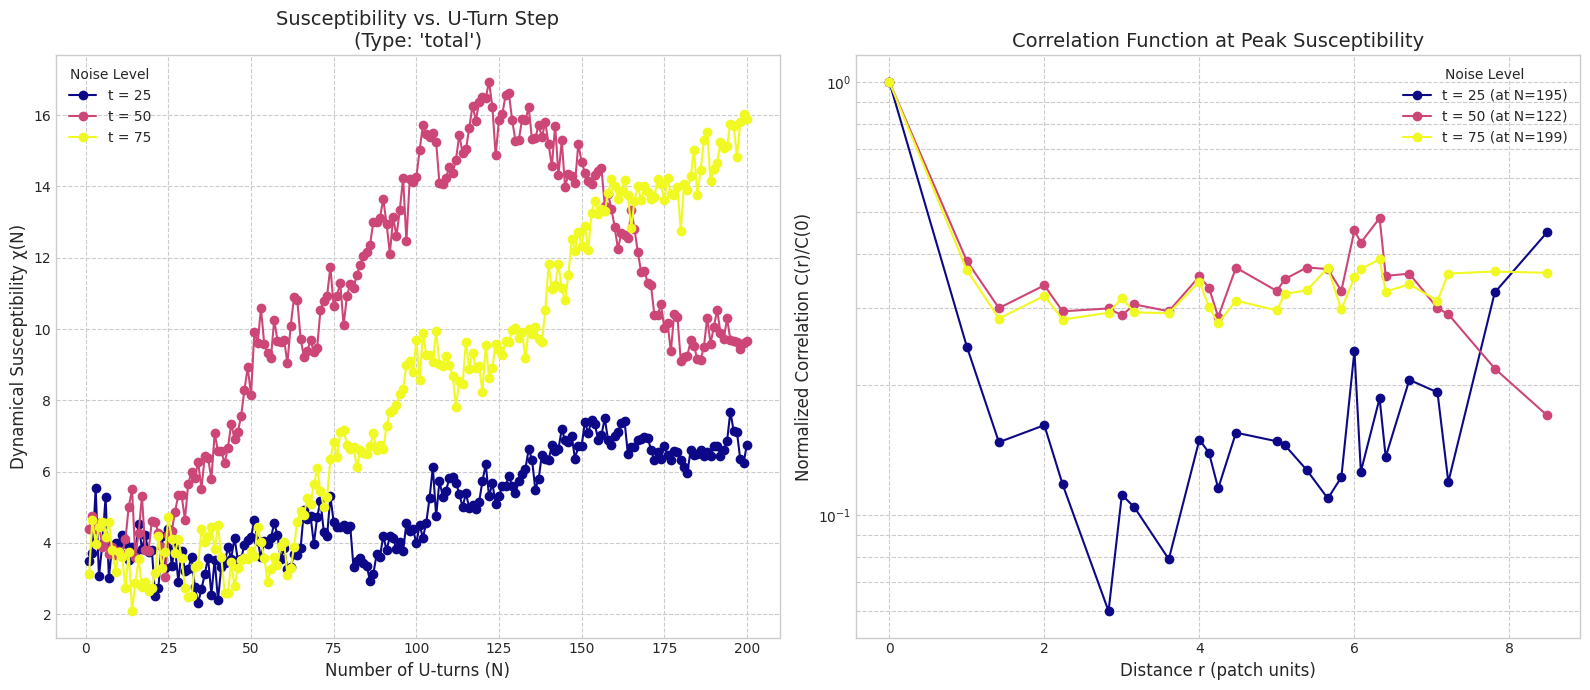

In [23]:
if all_susceptibilities:
    # --- Create a color map for the different noise levels ---
    noise_steps = sorted(all_susceptibilities.keys())
    colors = plt.cm.plasma(np.linspace(0, 1, len(noise_steps)))

    # --- Create a two-panel figure ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- Panel 1: Susceptibility vs. U-turn Step ---
    for i, t in enumerate(noise_steps):
        steps = list(all_susceptibilities[t].keys())
        susceptibilities = list(all_susceptibilities[t].values())
        ax1.plot(steps, susceptibilities, 'o-', color=colors[i], label=f't = {t}')
    
    ax1.set_xlabel("Number of U-turns (N)", fontsize=12)
    ax1.set_ylabel("Dynamical Susceptibility χ(N)", fontsize=12)
    ax1.set_title(f"Susceptibility vs. U-Turn Step\n(Type: '{ANALYSIS_TYPE}')", fontsize=14)
    ax1.legend(title="Noise Level")
    ax1.grid(True, which='both', linestyle='--')

    # --- Panel 2: Correlation Function vs. Distance ---
    for i, t in enumerate(noise_steps):
        if t in all_correlation_functions:
            data = all_correlation_functions[t]
            r, C_r, peak_N = data['r'], data['C_r'], data['peak_N']
            ax2.plot(r, C_r, 'o-', color=colors[i], label=f't = {t} (at N={peak_N})')
    
    ax2.set_xlabel("Distance r (patch units)", fontsize=12)
    ax2.set_ylabel("Normalized Correlation C(r)/C(0)", fontsize=12)
    ax2.set_title("Correlation Function at Peak Susceptibility", fontsize=14)
    ax2.set_yscale('log')
    ax2.legend(title="Noise Level")
    ax2.grid(True, which='both', linestyle='--')

    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(image_base_dir, f"comparative_analysis_{ANALYSIS_TYPE}.png")
    plt.savefig(save_path, dpi=300)
    print(f"✅ Comparative analysis plot saved to: {save_path}")
    
    plt.show()

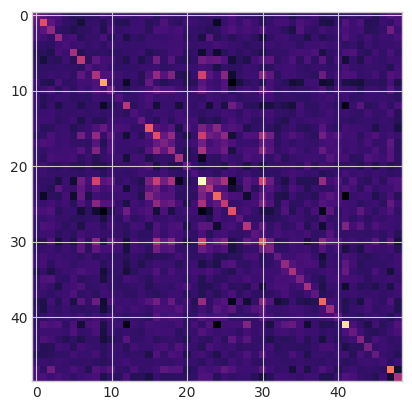

42.916784378363154

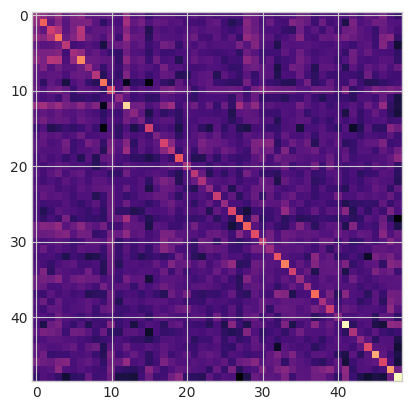

In [28]:
plt.imshow(correlation_matrices[1], cmap = 'magma')
plt.show()
plt.imshow(correlation_matrices[100], cmap = 'magma')


np.trace(correlation_matrices[1])

# Steering Experiments

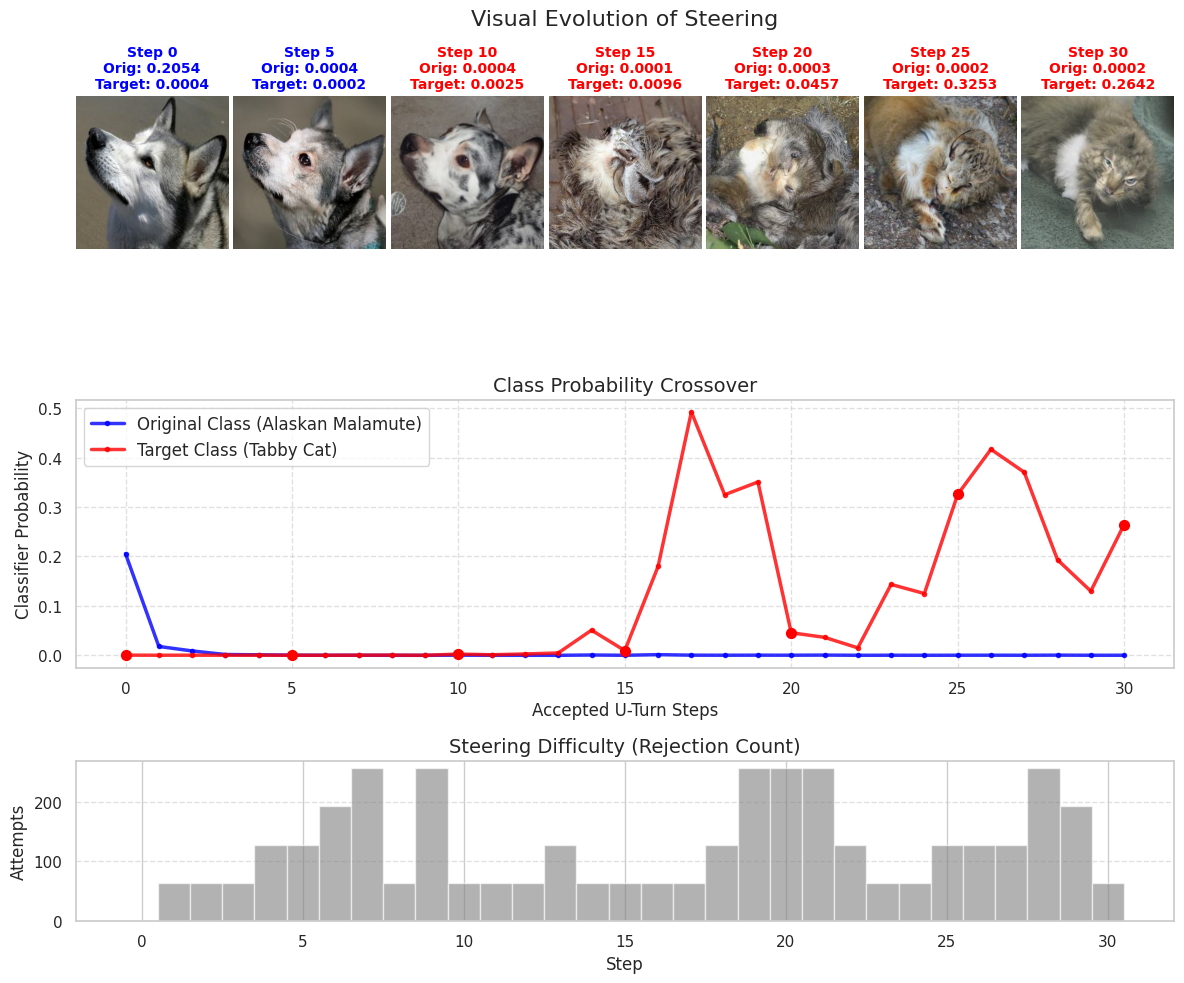

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Set style
sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
# Path to the specific experiment you ran
# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering/ILSVRC2012_val_00000729/target_281/noise_200"

# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_v4/ILSVRC2012_val_00000729/target_281/noise_500_p0.0_b5_r5"

# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_optimized/ILSVRC2012_val_00000729/target_281/noise_125_p0.0_b32_r2"
# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_optimized/ILSVRC2012_val_00000729/target_281/noise_100_p1.0_b54_r1"

RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_force_analysis/ILSVRC2012_val_00000729/target_281/noise_100_p1.0_b64_r4"


DATA_FILE = os.path.join(RESULTS_DIR, "steering_data.npz")



# --- LOAD DATA ---
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"Data not found at {DATA_FILE}")

data = np.load(DATA_FILE)
probs_orig = data['probs_orig']
probs_target = data['probs_target']
attempts = data['attempts']
steps = np.arange(len(probs_orig))

# --- VISUALIZATION SETUP ---
# Create a figure with 2 rows: Images on top, Plots on bottom
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.6]) # 3 rows (Images, Probs, Attempts)

# --- ROW 1: IMAGE EVOLUTION ---
# Select milestones to display (Start, 25, 50, 75, End)
# milestones = [0,4,6, 8]
milestones = np.arange(0,50,5)
# Ensure we don't go out of bounds if the run was short
valid_milestones = [m for m in milestones if m < len(steps)]

ax_images = fig.add_subplot(gs[0, :])
ax_images.axis('off')
ax_images.set_title("Visual Evolution of Steering", fontsize=16, pad=10)

# Create sub-axes for images within the top row space
sub_gs = gs[0, :].subgridspec(1, len(valid_milestones))

for i, step_idx in enumerate(valid_milestones):
    ax = fig.add_subplot(sub_gs[0, i])
    
    # Load image
    img_path = os.path.join(RESULTS_DIR, f"step_{step_idx:03d}.jpeg")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
    else:
        ax.text(0.5, 0.5, "Missing", ha='center')
        
    # Add stats to title
    p_o = probs_orig[step_idx]
    p_t = probs_target[step_idx]
    title = f"Step {step_idx}\nOrig: {p_o:.4f}\nTarget: {p_t:.4f}"
    
    # Color code title based on which class is winning
    title_color = 'red' if p_t > p_o else 'blue'
    
    ax.set_title(title, fontsize=10, color=title_color, fontweight='bold')
    ax.axis('off')

# --- ROW 2: PROBABILITY TRAJECTORY ---
ax_prob = fig.add_subplot(gs[1, :])

ax_prob.plot(steps, probs_orig,'.-', label="Original Class (Alaskan Malamute)", color='blue', linewidth=2.5, alpha=0.8)
ax_prob.plot(steps, probs_target, '.-',  label="Target Class (Tabby Cat)", color='red', linewidth=2.5, alpha=0.8)

# Add markers corresponding to the images shown above
# ax_prob.scatter(valid_milestones, probs_orig[valid_milestones], color='blue', s=50, zorder=5)
ax_prob.scatter(valid_milestones, probs_target[valid_milestones], color='red', s=50, zorder=5)

ax_prob.set_xlabel("Accepted U-Turn Steps", fontsize=12)
ax_prob.set_ylabel("Classifier Probability", fontsize=12)
ax_prob.set_title("Class Probability Crossover", fontsize=14)
ax_prob.legend(fontsize=12)
ax_prob.grid(True, linestyle='--', alpha=0.6)

# --- ROW 3: ACCEPTANCE DIFFICULTY ---
ax_diff = fig.add_subplot(gs[2, :])
ax_diff.bar(steps, attempts, color='gray', alpha=0.6, width=1.0)
ax_diff.set_xlabel("Step", fontsize=12)
ax_diff.set_ylabel("Attempts", fontsize=12)
ax_diff.set_title("Steering Difficulty (Rejection Count)", fontsize=14)
ax_diff.grid(True, axis='y', linestyle='--', alpha=0.6)

# --- FINALIZE ---
plt.tight_layout()
plt.show()

### 1. Mathematical Notion of the "Force"

We can define the **Restorative Force $F$** at a point $x$ as the expected change in the score function $S(x)$ after a random U-turn $U(x)$:

$$ F(x) = \mathbb{E}_{\epsilon} [ S(U(x, \epsilon)) - S(x) ] $$

*   If $F(x) < 0$, the manifold is actively resisting your steering (pushing you back down the hill).
*   If $F(x) > 0$, the manifold naturally guides you towards the target.
*   We can estimate this by saving the mean (and variance) of the score changes for *all* batch candidates, not just the winner.


✅ Loaded 60 batches of force data.


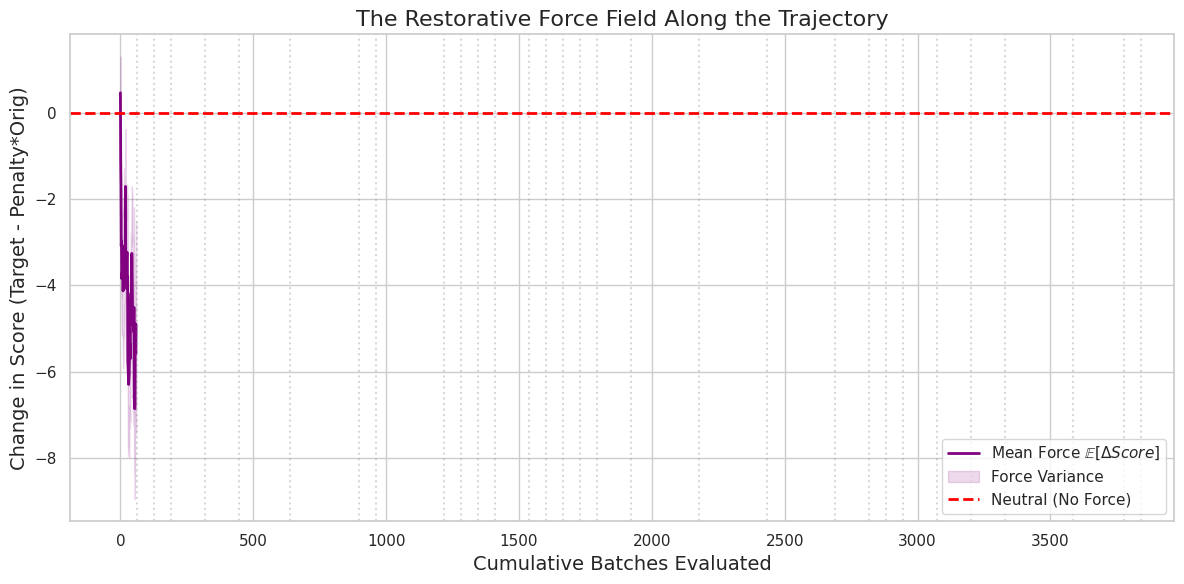

Average Global Force: -4.2698 (Resisting the steering)


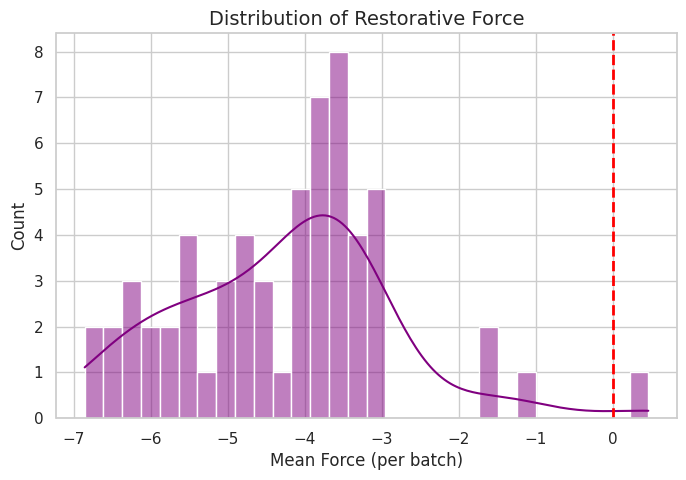

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
# Path to the specific experiment output where you saved force_stats.npz
# Example path based on your previous messages:
RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_force_analysis/ILSVRC2012_val_00000729/target_281/noise_100_p1.0_b64_r4"
DATA_FILE = os.path.join(RESULTS_DIR, "force_stats.npz")

# --- LOAD DATA ---
if not os.path.exists(DATA_FILE):
    print(f"❌ File not found: {DATA_FILE}")
    print("Make sure you ran the updated script that saves 'force_stats.npz'")
else:
    data = np.load(DATA_FILE)
    # The shape should be (Total_Batches, 2) where col 0 is Mean, col 1 is Std
    force_history = data['force'] 
    
    # We also load steering data to mark where steps were accepted vs forced
    steering_data = np.load(os.path.join(RESULTS_DIR, "steering_data.npz"))
    attempts_per_step = steering_data['attempts'] # Number of batches per step
    
    print(f"✅ Loaded {len(force_history)} batches of force data.")

    # --- PLOT 1: The Restorative Force Trajectory ---
    plt.figure(figsize=(12, 6))
    
    means = force_history[:, 0]
    stds = force_history[:, 1]
    batch_indices = np.arange(len(means))

    # Plot the mean force
    plt.plot(batch_indices, means, color='purple', label="Mean Force $\mathbb{E}[\Delta Score]$", linewidth=2)
    
    # Fill standard deviation to show the "noise" (randomness of the force)
    plt.fill_between(batch_indices, means - stds, means + stds, color='purple', alpha=0.15, label="Force Variance")

    # Add a zero line
    plt.axhline(0, color='red', linestyle='--', linewidth=2, label="Neutral (No Force)")

    # --- Overlay Step Transitions ---
    # We want to see if the force changes after we successfully take a step
    cumulative_batches = 0
    for i, attempts in enumerate(attempts_per_step):
        if i == 0: continue # Skip step 0 (init)
        cumulative_batches += attempts
        # Draw a vertical line for each accepted step
        plt.axvline(cumulative_batches, color='gray', alpha=0.3, linestyle=':')
        # plt.axvline(batch_indices, color='gray', alpha=0.3, linestyle=':')
    
    
    # plt.plot(cumulative_batches, means, color='purple', label="Mean Force $\mathbb{E}[\Delta Score]$", linewidth=2)

    plt.xlabel("Cumulative Batches Evaluated", fontsize=14)
    plt.ylabel("Change in Score (Target - Penalty*Orig)", fontsize=14)
    plt.title("The Restorative Force Field Along the Trajectory", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: Force Histogram (Global) ---
    plt.figure(figsize=(8, 5))
    sns.histplot(means, kde=True, color='purple', bins=30)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel("Mean Force (per batch)", fontsize=12)
    plt.title("Distribution of Restorative Force", fontsize=14)
    
    mean_of_means = np.mean(means)
    status = "Resisting" if mean_of_means < 0 else "Assisting"
    print(f"Average Global Force: {mean_of_means:.4f} ({status} the steering)")
    
    plt.show()

In [43]:
# force_history.shape

(60, 2)

In [36]:
import torch as th
from PIL import Image
import os
import sys
import json
import urllib.request
import torch.nn.functional as F

# Setup path
sys.path.insert(0, "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion")
from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

# CONFIG
IMAGE_PATH = "/work/pcsl/Noam/sequential_diffusion/results/steering/ILSVRC2012_val_00000729/target_281/noise_200/step_050.jpeg"



IMAGE_PATH = "/work/pcsl/Noam/sequential_diffusion/results/steering_force_analysis/ILSVRC2012_val_00000729/target_281/noise_100_p1.0_b64_r4/step_030.jpeg"

CLASSIFIER_NAME = "convnext_base"

# Load Labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = json.loads(urllib.request.urlopen(url).read().decode())

# Load Model
dist_util.setup_dist()
device = dist_util.dev()
classifier, preprocess, _ = load_classifier(CLASSIFIER_NAME)
classifier.to(device)
classifier.eval()



# Predict
img = Image.open(IMAGE_PATH).convert("RGB")
img = img.resize((256, 256), Image.BICUBIC) # Ensure correct size

# --- FIX: Convert PIL to Tensor [-1, 1] ---
import numpy as np
arr = np.array(img).astype(np.float32) / 127.5 - 1.0
batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
# ------------------------------------------

with th.no_grad():
    # Now pass the tensor to preprocess
    logits = classifier(preprocess(batch))
    probs = F.softmax(logits, dim=1)
    
top_probs, top_indices = th.topk(probs, 5)

print(f"\n--- Analysis of Step 50 ---")
for i in range(5):
    idx = top_indices[0][i].item()
    prob = top_probs[0][i].item()
    print(f"{i+1}. {labels[idx]} (Index {idx}): {prob:.4f}")



--- Analysis of Step 50 ---
1. tabby cat (Index 281): 0.2308
2. Persian cat (Index 283): 0.1241
3. lynx (Index 287): 0.0846
4. Egyptian Mau (Index 285): 0.0386
5. tiger cat (Index 282): 0.0248


In [21]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from PIL import Image
from torchvision import transforms

# --- PATH CONFIGURATION ---
PROJECT_ROOT = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion"
sys.path.insert(0, PROJECT_ROOT)

from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

# --- EXPERIMENT CONFIGURATION ---
CLASSIFIER_NAME = "convnext_base"
# STEERING_TRAJ_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering/ILSVRC2012_val_00000729/target_281/noise_200"


STEERING_TRAJ_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_optimized/ILSVRC2012_val_00000729/target_281/noise_125_p0.0_b32_r2"


# Layers to visualize and track
# (ConvNeXt uses 'features.X' naming conventions)
LAYERS_TO_ANALYZE = [
    "features.0",   # Early visual (Edges/Colors)
    "features.1",   # Mid-level (Textures)
    "features.2",   # Mid-level (Textures)
    "features.3",   # Mid-level (Textures)
    "features.4",   # High-level (Parts)
    "features.5",   # Mid-level (Textures)
    "features.6",   # Semantic (Objects)
    "classifier"    # Final Class prediction
]

# Setup Device & Model
dist_util.setup_dist()
device = dist_util.dev()

print(f"Loading {CLASSIFIER_NAME}...")
classifier, preprocess, module_names = load_classifier(CLASSIFIER_NAME)
classifier.to(device)
classifier.eval()
print("Model loaded.")

Loading convnext_base...
Model loaded.


Optimizing features.7...


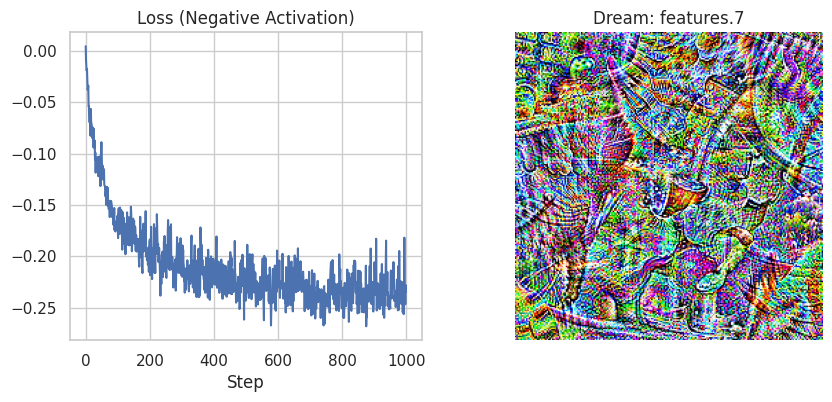

In [54]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# --- CONFIG ---
# LAYER_NAME = "features.6" # Try features.0, features.4, features.6
LAYER_NAME = "features.7" # Try features.0, features.4, features.6
NUM_STEPS = 1000
LR = 0.1 # Aggressive learning rate

# --- SETUP ---
# Ensure classifier is loaded
if 'classifier' not in locals():
    print("Please run the 'Load Model' cell first.")
else:
    # 1. Initialize with Mean Grey (0.5) + Significant Noise
    # Standard deviation 0.1 ensures we escape dead ReLU zones
    img = (th.randn(1, 3, 224, 224, device=device) * 0.1 + 0.5).requires_grad_(True)
    
    optimizer = th.optim.AdamW([img], lr=LR)
    
    # 2. Define Transforms (Jitter + Norm)
    # Explicit ImageNet Normalization (Mean/Std) manually to be safe
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # Hook
    activations = {}
    def hook(module, input, output):
        activations['act'] = output
    
    layer_module = dict([*classifier.named_modules()])[LAYER_NAME]
    handle = layer_module.register_forward_hook(hook)
    
    print(f"Optimizing {LAYER_NAME}...")
    losses = []
    
    for i in range(NUM_STEPS):
        optimizer.zero_grad()
        
        # A. Jitter (Random shift)
        ox, oy = np.random.randint(-4, 5, 2)
        jittered_img = th.roll(img, shifts=(ox, oy), dims=(2, 3))
        
        # B. Robust Preprocessing
        # We manually apply normalization to ensure we aren't relying on a black-box function
        # Input 'jittered_img' is roughly [0, 1]. Normalize expects that.
        input_tensor = normalize(jittered_img)
        
        # C. Forward
        classifier(input_tensor)
        
        # D. Loss: Mean Activation
        loss = -activations['act'].mean()
        losses.append(loss.item())
        
        loss.backward()
        
        # E. Gradient Normalization (CRITICAL FIX)
        # This ensures we take steps of consistent size, regardless of layer depth
        if img.grad is not None:
            img.grad /= (img.grad.std() + 1e-8)
        
        optimizer.step()
        
        # F. Constrain to Valid Image Range [0, 1]
        with th.no_grad():
            img.clamp_(0, 1)

    handle.remove()
    
    # --- VISUALIZATION ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot Loss (Should go DOWN)
    ax1.plot(losses)
    ax1.set_title("Loss (Negative Activation)")
    ax1.set_xlabel("Step")
    
    # Plot Image
    img_vis = img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
    ax2.imshow(img_vis)
    ax2.set_title(f"Dream: {LAYER_NAME}")
    ax2.axis('off')
    
    plt.show()

Optimizing features.0 (Channels: [ 31  28  86 108])...


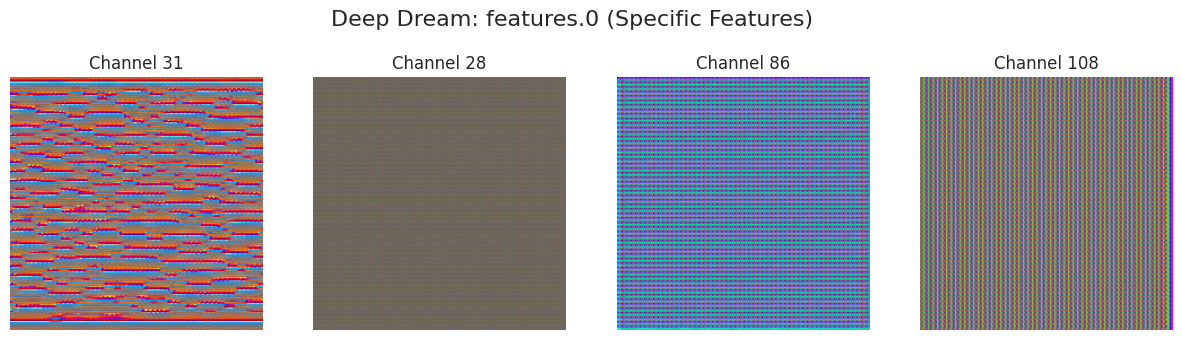

In [59]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# --- CONFIG ---
LAYER_NAME = "features.0" # Try features.6 or features.7 for high-level objects
NUM_STEPS = 200
LR = 0.05
NUM_CHANNELS_TO_SHOW = 4 # How many distinct features to look for

# --- SETUP ---
if 'classifier' not in locals():
    print("Please run the 'Load Model' cell first.")
else:
    # 1. Define Utilities
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # Gaussian blur helps smooth out high-frequency noise (the "static")
    blur = transforms.GaussianBlur(kernel_size=5, sigma=0.5)

    # 2. Hook Setup
    activations = {}
    def hook(module, input, output):
        activations['act'] = output
    
    layer_module = dict([*classifier.named_modules()])[LAYER_NAME]
    handle = layer_module.register_forward_hook(hook)

    # 3. Determine number of channels in this layer
    # Run a dummy pass to get shape
    dummy = th.zeros(1, 3, 224, 224, device=device)
    classifier(dummy)
    num_available_channels = activations['act'].shape[1]
    
    # Pick random channels to visualize (e.g., Channel 15 might be 'eyes')
    target_channels = np.random.choice(num_available_channels, NUM_CHANNELS_TO_SHOW, replace=False)
    # Or set manually: target_channels = [10, 55, 120, 200] 

    print(f"Optimizing {LAYER_NAME} (Channels: {target_channels})...")
    
    results = []

    for channel_idx in target_channels:
        # Initialize with gray + noise
        img = (th.randn(1, 3, 224, 224, device=device) * 0.01 + 0.5).requires_grad_(True)
        optimizer = th.optim.Adam([img], lr=LR)
        
        for i in range(NUM_STEPS):
            optimizer.zero_grad()
            
            # A. Jitter (Translation Invariance)
            ox, oy = np.random.randint(-4, 5, 2)
            jittered_img = th.roll(img, shifts=(ox, oy), dims=(2, 3))
            
            # B. Preprocess
            input_tensor = normalize(jittered_img)
            
            # C. Forward
            classifier(input_tensor)
            
            # D. Loss: Maximize ONLY the specific channel
            # We average over spatial dimensions (H, W) but select only index [0, channel_idx]
            act = activations['act']
            loss = -act[0, channel_idx].mean()
            
            loss.backward()
            
            # E. Gradient Normalization
            if img.grad is not None:
                img.grad /= (img.grad.std() + 1e-8)
            
            optimizer.step()
            
            # F. Regularization: Periodic Blur
            # This is the key to getting smooth, object-like features
            if i % 10 == 0:
                with th.no_grad():
                    img.copy_(blur(img))
            
            # G. Clamp to valid range
            with th.no_grad():
                img.clamp_(0, 1)
        
        # Save result
        img_vis = img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
        results.append((channel_idx, img_vis))

    handle.remove()
    
    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, NUM_CHANNELS_TO_SHOW, figsize=(15, 4))
    if NUM_CHANNELS_TO_SHOW == 1: axes = [axes]
    
    for ax, (ch, img) in zip(axes, results):
        ax.imshow(img)
        ax.set_title(f"Channel {ch}")
        ax.axis('off')
    
    plt.suptitle(f"Deep Dream: {LAYER_NAME} (Specific Features)", fontsize=16)
    plt.show()

Tracking features across 20 steering steps...


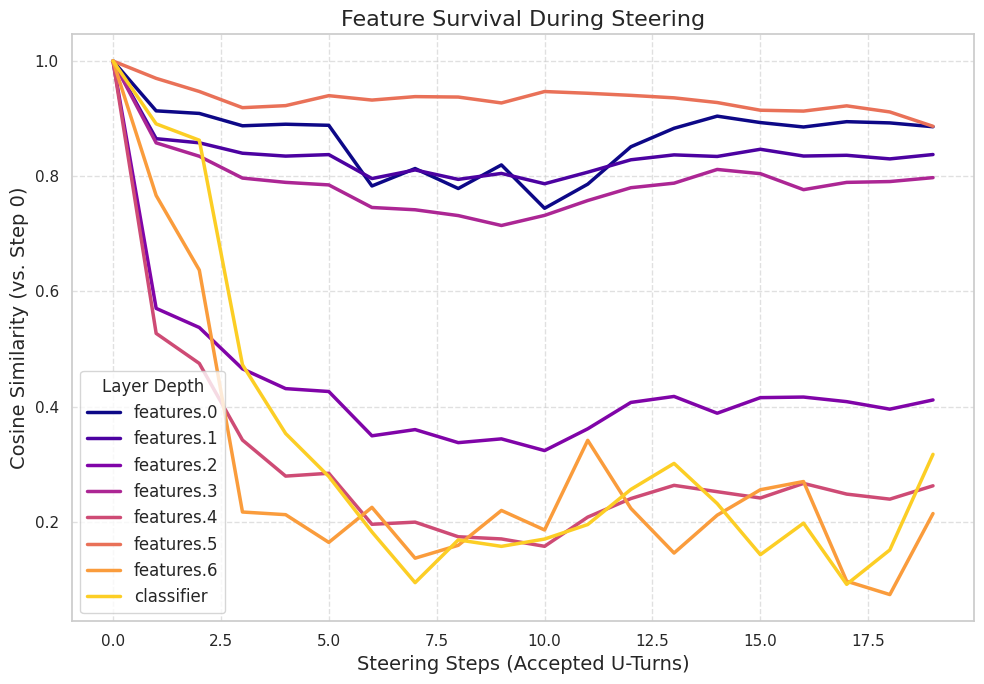

In [30]:
# --- 1. Load Steering Images ---
image_files = sorted([f for f in os.listdir(STEERING_TRAJ_DIR) if f.endswith(".jpeg")])
# Sort numerically by step number
image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

print(f"Tracking features across {len(image_files)} steering steps...")

# --- 2. Setup Hooks Again ---
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hooks = []
for layer in LAYERS_TO_ANALYZE:
    layer_module = dict([*classifier.named_modules()])[layer]
    hooks.append(layer_module.register_forward_hook(get_activation(layer)))

# --- 3. Compute Reference (Step 0) ---
img0_path = os.path.join(STEERING_TRAJ_DIR, image_files[0])
img0 = Image.open(img0_path).convert("RGB")
# Convert to [-1, 1] tensor as expected by this classifier setup
arr0 = np.array(img0).astype(np.float32) / 127.5 - 1.0
tensor0 = th.from_numpy(arr0).permute(2, 0, 1).unsqueeze(0).to(device)

with th.no_grad():
    classifier(preprocess(tensor0))

# Save flat copies of reference activations
ref_activations = {k: v.clone().flatten() for k, v in activations.items()}

# --- 4. Process Trajectory ---
cosine_history = {l: [] for l in LAYERS_TO_ANALYZE}
cosine_sim_func = th.nn.CosineSimilarity(dim=0)

for img_file in image_files:
    # Load and Preprocess
    img_path = os.path.join(STEERING_TRAJ_DIR, img_file)
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img).astype(np.float32) / 127.5 - 1.0
    tensor = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
    
    with th.no_grad():
        classifier(preprocess(tensor))
    
    # Compare against reference
    for layer in LAYERS_TO_ANALYZE:
        curr_act = activations[layer].flatten()
        ref_act = ref_activations[layer]
        sim = cosine_sim_func(curr_act, ref_act).item()
        cosine_history[layer].append(sim)

# Cleanup
for h in hooks: h.remove()

# --- 5. Plot Results ---
plt.figure(figsize=(10, 7))
colors = plt.cm.plasma(np.linspace(0, 0.9, len(LAYERS_TO_ANALYZE)))

for i, layer in enumerate(LAYERS_TO_ANALYZE):
    plt.plot(cosine_history[layer], label=layer, color=colors[i], linewidth=2.5)

plt.xlabel("Steering Steps (Accepted U-Turns)", fontsize=14)
plt.ylabel("Cosine Similarity (vs. Step 0)", fontsize=14)
plt.title(f"Feature Survival During Steering", fontsize=16)
plt.legend(title="Layer Depth", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- Analysis of Step 50 ---
1. Alaskan Malamute (Index 249): 0.3322
2. husky (Index 248): 0.2548
3. Siberian Husky (Index 250): 0.1015
4. Norwegian Elkhound (Index 174): 0.0178
5. Alaskan tundra wolf (Index 270): 0.0084


In [73]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.transforms import Resize
import torch.nn.functional as F
import os
import sys

# --- CONFIG ---
PROJECT_ROOT = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion"
MODEL_PATH = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/models/256x256_diffusion_uncond.pt"
IMAGE_PATH = "/work/pcsl/Noam/diffusion_datasets/selected_images/ILSVRC2012_val_00000729.JPEG"

TARGET_IDX = 281 # Cat
NOISE_STEP = 100 
BATCH_SIZE = 20
NUM_BATCHES = 5 # Total 100 samples

# --- SETUP ---
sys.path.insert(0, PROJECT_ROOT)
from guided_diffusion.script_util import model_and_diffusion_defaults, create_model_and_diffusion, args_to_dict
from guided_diffusion.torch_classifiers import load_classifier

def perform_single_uturn(model, diffusion, start_tensor, noise_step, device):
    with th.no_grad():
        t_batch = th.tensor([noise_step] * start_tensor.shape[0], device=device)
        noisy_image = diffusion.q_sample(start_tensor, t_batch)
        img = noisy_image
        indices = list(range(noise_step))[::-1]
        for i in indices:
            t = th.tensor([i] * img.shape[0], device=device)
            out = diffusion.p_sample(model=model, x=img, t=t, clip_denoised=True)
            img = out["sample"]
        return img

# Load Models
device = "cuda" if th.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- FIX: ADD 'learn_sigma': True ---
defaults = model_and_diffusion_defaults()
defaults.update({
    'model_path': MODEL_PATH,
    'image_size': 256,
    'class_cond': False,
    'diffusion_steps': 1000,
    'timestep_respacing': "",
    'use_fp16': True,
    
    # CRITICAL MISSING FLAG:
    'learn_sigma': True, 
    
    # Architecture Flags:
    'num_channels': 256,
    'num_res_blocks': 2,
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "32,16,8",
    'resblock_updown': True,
    'use_scale_shift_norm': True
})
# --------------------------------------------

class Args: pass
args = Args()
for k, v in defaults.items(): setattr(args, k, v)

print("Loading diffusion model...")
model, diffusion = create_model_and_diffusion(**args_to_dict(args, model_and_diffusion_defaults().keys()))
model.load_state_dict(th.load(args.model_path, map_location="cpu"))
model.to(device); model.eval()
if args.use_fp16: model.convert_to_fp16()

print("Loading classifier...")
classifier, preprocess, _ = load_classifier("convnext_base")
classifier.to(device); classifier.eval()

# Load Image
print("Processing image...")
diffusion_resize = Resize([256, 256], Image.BICUBIC)
start_pil = diffusion_resize(Image.open(IMAGE_PATH).convert("RGB"))
start_tensor = th.tensor(np.array(start_pil)).float() / 127.5 - 1
start_tensor = start_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

# Initial Score
with th.no_grad():
    logits = classifier(preprocess(start_tensor))
    probs = F.softmax(logits, dim=1)
    initial_prob_target = probs[0, TARGET_IDX].item()
    initial_logit_target = logits[0, TARGET_IDX].item()

# Run Random U-Turns
print(f"Running {BATCH_SIZE * NUM_BATCHES} random U-turns at noise {NOISE_STEP}...")
deltas_prob = []
deltas_logit = []

with th.no_grad():
    for b in range(NUM_BATCHES):
        batch_input = start_tensor.repeat(BATCH_SIZE, 1, 1, 1)
        output_batch = perform_single_uturn(model, diffusion, batch_input, NOISE_STEP, device)
        
        logits_out = classifier(preprocess(output_batch))
        probs_out = F.softmax(logits_out, dim=1)
        
        p_t = probs_out[:, TARGET_IDX].cpu().numpy()
        l_t = logits_out[:, TARGET_IDX].cpu().numpy()
        
        deltas_prob.extend(p_t - initial_prob_target)
        deltas_logit.extend(l_t - initial_logit_target)

# Visualization
pos_count = sum(d > 0 for d in deltas_logit)
success_rate = pos_count / len(deltas_logit) * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(deltas_logit, kde=True, color='purple', bins=20)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label="Neutral")
plt.title(f"Change in Target Logit (Noise={NOISE_STEP})")
plt.xlabel("Delta Logit (Positive = Towards Cat)")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(deltas_prob, kde=True, color='green', bins=20)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title(f"Change in Target Probability")
plt.xlabel("Delta Prob")

plt.suptitle(f"Restorative Force Measurement (Success Rate: {success_rate:.1f}%)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Mean Logit Change: {np.mean(deltas_logit):.4f}")

Using device: cuda
Loading diffusion model...


KeyboardInterrupt: 

In [75]:
import torch as th
import numpy as np
from PIL import Image
from torchvision.transforms import Resize
import torch.nn.functional as F
import sys
import os

# --- PATHS ---
sys.path.insert(0, "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion")
from guided_diffusion.script_util import model_and_diffusion_defaults, create_model_and_diffusion, args_to_dict
from guided_diffusion.torch_classifiers import load_classifier

# --- CONFIG ---
IMAGE_PATH = "/work/pcsl/Noam/diffusion_datasets/selected_images/ILSVRC2012_val_00000729.JPEG"
ORIG_IDX = 249 # Malamute
TARGET_IDX = 281 # Tabby
NOISE_STEP = 100
RESPACING = "250" # <--- The critical difference
BATCH_SIZE = 50
NUM_TRIALS = 4 # Total 200 attempts

def perform_single_uturn(model, diffusion, start_tensor, noise_step, device):
    with th.no_grad():
        t_batch = th.tensor([noise_step] * start_tensor.shape[0], device=device)
        noisy_image = diffusion.q_sample(start_tensor, t_batch)
        img = noisy_image
        indices = list(range(noise_step))[::-1]
        for i in indices:
            t = th.tensor([i] * img.shape[0], device=device)
            out = diffusion.p_sample(model=model, x=img, t=t, clip_denoised=True)
            img = out["sample"]
        return img

# Setup
dist_util = type('obj', (object,), {'dev': lambda: "cuda" if th.cuda.is_available() else "cpu"})
device = dist_util.dev()


# Update your defaults dictionary to this:
defaults = model_and_diffusion_defaults()
defaults.update({
    'model_path': "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/models/256x256_diffusion_uncond.pt",
    'image_size': 256,
    'class_cond': False,
    'diffusion_steps': 1000,
    'timestep_respacing': RESPACING,
    'use_fp16': True,
    
    # --- ADD THESE FLAGS ---
    'num_channels': 256,
    'num_res_blocks': 2,
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "32,16,8",
    'resblock_updown': True,
    'use_scale_shift_norm': True,
    'learn_sigma': True # Important!
    # -----------------------
})

args = type('Args', (), defaults)()

print(f"Loading Diffusion (Respacing={RESPACING})...")

# Create a filtered dictionary for the function
model_config = args_to_dict(args, model_and_diffusion_defaults().keys())
model, diffusion = create_model_and_diffusion(**model_config)


model.load_state_dict(th.load(args.model_path, map_location="cpu"))
model.to(device); model.eval(); model.convert_to_fp16()

print("Loading Classifier...")
classifier, preprocess, _ = load_classifier("convnext_base")
classifier.to(device); classifier.eval()

# Load Image
img_pil = Resize([256, 256], Image.BICUBIC)(Image.open(IMAGE_PATH).convert("RGB"))
start_tensor = th.tensor(np.array(img_pil)).float() / 127.5 - 1
start_tensor = start_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

# Initial Score
with th.no_grad():
    logits = classifier(preprocess(start_tensor))
    score_0 = (logits[0, TARGET_IDX] - 0.0 * logits[0, ORIG_IDX]).item() # Penalty=0 for test

print(f"Initial Score: {score_0:.4f}")
print(f"Running {BATCH_SIZE*NUM_TRIALS} attempts...")

successes = 0
total = 0

with th.no_grad():
    for _ in range(NUM_TRIALS):
        batch = start_tensor.repeat(BATCH_SIZE, 1, 1, 1)
        out = perform_single_uturn(model, diffusion, batch, NOISE_STEP, device)
        
        logits = classifier(preprocess(out))
        scores = logits[:, TARGET_IDX] # - 0.0 * logits[:, ORIG_IDX]
        
        improved = (scores > score_0).sum().item()
        successes += improved
        total += BATCH_SIZE
        print(f"Batch result: {improved}/{BATCH_SIZE} improved.")

print(f"Final Success Rate at Noise {NOISE_STEP} (Respaced {RESPACING}): {successes}/{total} ({successes/total*100:.2f}%)")

Loading Diffusion (Respacing=250)...
Loading Classifier...
Initial Score: 0.5134
Running 200 attempts...
Batch result: 7/50 improved.
Batch result: 4/50 improved.
Batch result: 6/50 improved.
Batch result: 7/50 improved.
Final Success Rate at Noise 100 (Respaced 250): 24/200 (12.00%)


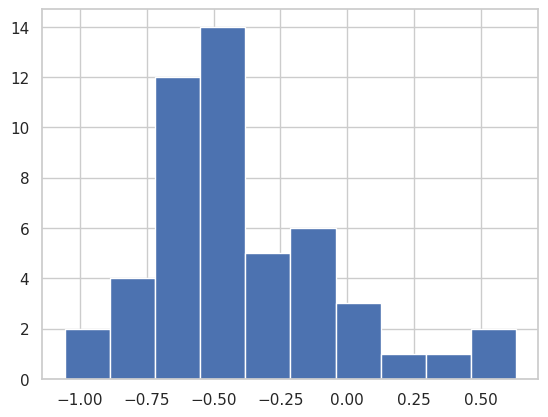

In [85]:
plt.hist(scores.cpu().detach()-score_0);

## Meta labels

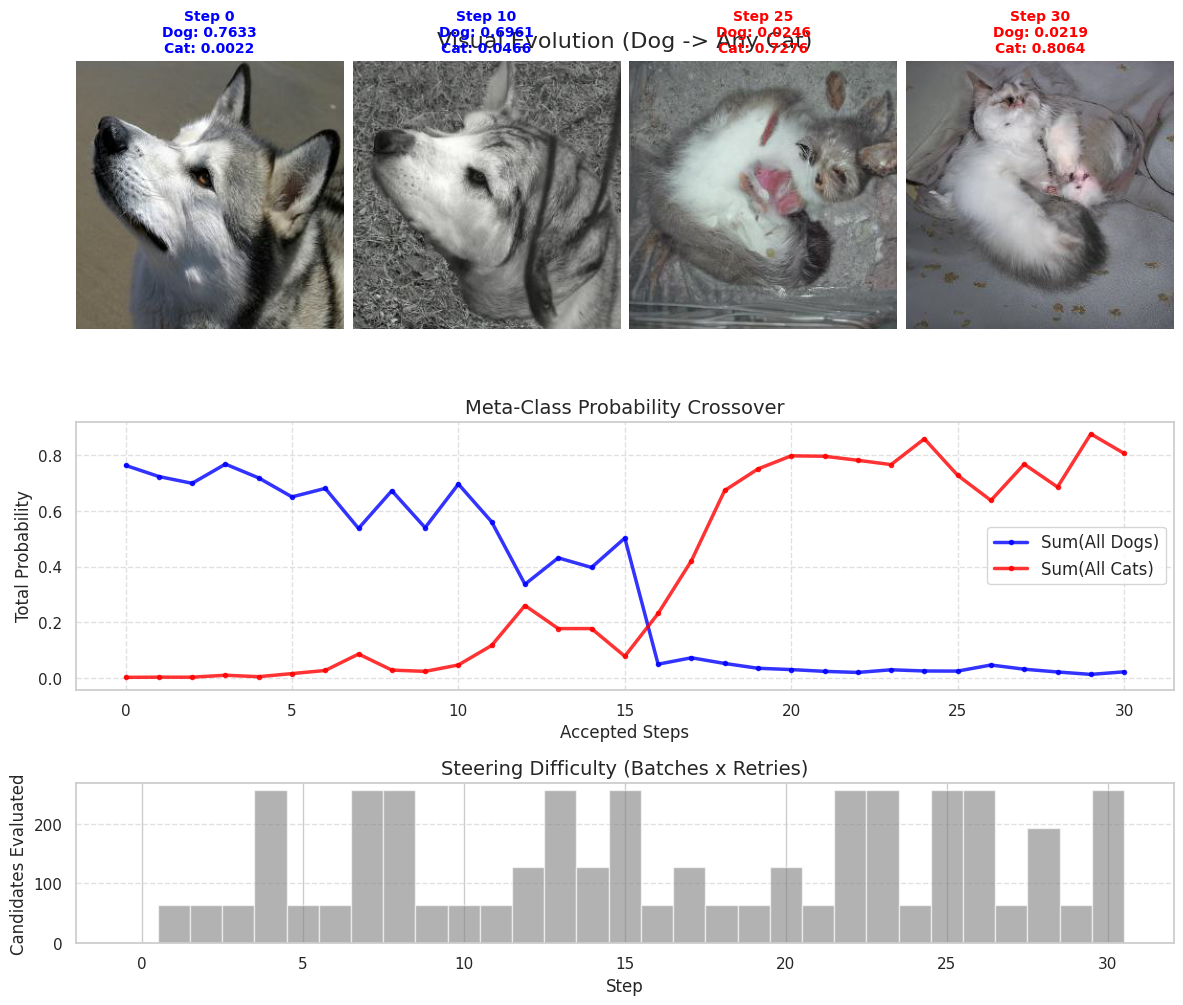

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Set style
sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0"
DATA_FILE = os.path.join(RESULTS_DIR, "steering_data.npz")

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"Data not found at {DATA_FILE}")

data = np.load(DATA_FILE)
# Note the new keys for Meta-Classes
probs_orig = data['probs_dog'] 
probs_target = data['probs_cat']
attempts = data['attempts']
steps = np.arange(len(probs_orig))

# --- VISUALIZATION ---
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.6])

# Row 1: Images
# milestones = np.arange(0,30,5)#[0, 10, 20, 30, 40]
milestones = [0, 10, 25, 30]
valid_milestones = [m for m in milestones if m < len(steps)]

ax_images = fig.add_subplot(gs[0, :])
ax_images.axis('off')
ax_images.set_title("Visual Evolution (Dog -> Any Cat)", fontsize=16, pad=10)

sub_gs = gs[0, :].subgridspec(1, len(valid_milestones))
for i, step_idx in enumerate(valid_milestones):
    ax = fig.add_subplot(sub_gs[0, i])
    img_path = os.path.join(RESULTS_DIR, f"step_{step_idx:03d}.jpeg")
    if os.path.exists(img_path):
        ax.imshow(Image.open(img_path))
    else:
        ax.text(0.5, 0.5, "Missing", ha='center')
    
    p_o = probs_orig[step_idx]
    p_t = probs_target[step_idx]
    title = f"Step {step_idx}\nDog: {p_o:.4f}\nCat: {p_t:.4f}"
    title_color = 'red' if p_t > p_o else 'blue'
    ax.set_title(title, fontsize=10, color=title_color, fontweight='bold')
    ax.axis('off')

# Row 2: Probabilities
ax_prob = fig.add_subplot(gs[1, :])
ax_prob.plot(steps, probs_orig, '.-', label="Sum(All Dogs)", color='blue', linewidth=2.5, alpha=0.8)
ax_prob.plot(steps, probs_target, '.-', label="Sum(All Cats)", color='red', linewidth=2.5, alpha=0.8)
ax_prob.set_xlabel("Accepted Steps", fontsize=12)
ax_prob.set_ylabel("Total Probability", fontsize=12)
ax_prob.set_title("Meta-Class Probability Crossover", fontsize=14)
ax_prob.legend(fontsize=12)
ax_prob.grid(True, linestyle='--', alpha=0.6)

# Row 3: Difficulty
ax_diff = fig.add_subplot(gs[2, :])
ax_diff.bar(steps, attempts, color='gray', alpha=0.6, width=1.0)
ax_diff.set_xlabel("Step", fontsize=12)
ax_diff.set_ylabel("Candidates Evaluated", fontsize=12)
ax_diff.set_title("Steering Difficulty (Batches x Retries)", fontsize=14)
ax_diff.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

✅ Loaded 58 batches of force data.


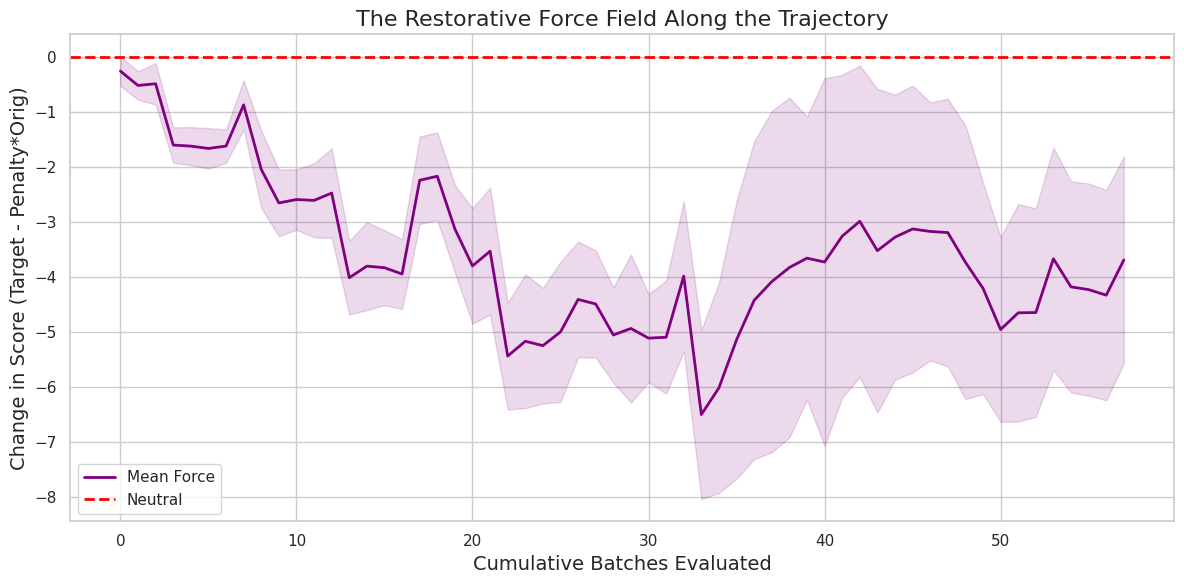

Average Global Force: -3.5850 (Resisting the steering)


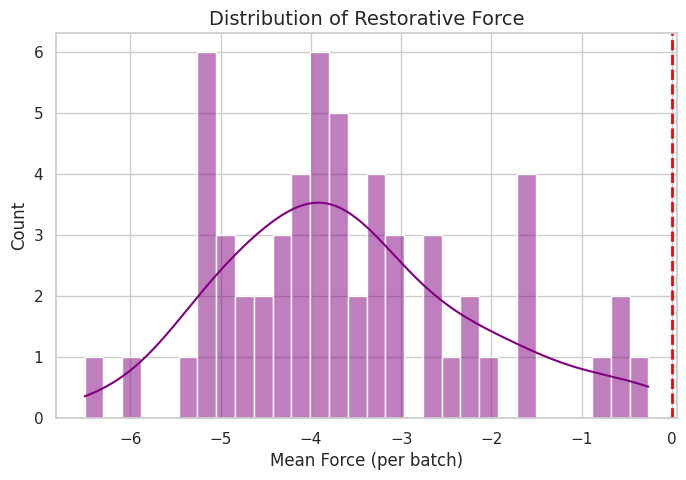

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
# Path to the specific experiment output where you saved force_stats.npz
# Example path based on your previous messages:
RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0"
DATA_FILE = os.path.join(RESULTS_DIR, "force_stats.npz")

# --- LOAD DATA ---
if not os.path.exists(DATA_FILE):
    print(f"❌ File not found: {DATA_FILE}")
    print("Make sure you ran the updated script that saves 'force_stats.npz'")
else:
    data = np.load(DATA_FILE)
    # The shape should be (Total_Batches, 2) where col 0 is Mean, col 1 is Std
    force_history = data['force'] 
    
    # We also load steering data to mark where steps were accepted vs forced
    steering_data = np.load(os.path.join(RESULTS_DIR, "steering_data.npz"))
    attempts_per_step = steering_data['attempts'] # Number of batches per step
    
    print(f"✅ Loaded {len(force_history)} batches of force data.")


    
    # --- PLOT 1: The Restorative Force Trajectory ---
    plt.figure(figsize=(12, 6))
    
    means = force_history[:, 0]
    stds = force_history[:, 1]
    
    # X-Axis is simply the index of the batch
    batch_indices = np.arange(len(means))

    # Plot the mean force
    plt.plot(batch_indices, means, color='purple', label="Mean Force", linewidth=2)
    plt.fill_between(batch_indices, means - stds, means + stds, color='purple', alpha=0.15)

    plt.axhline(0, color='red', linestyle='--', linewidth=2, label="Neutral")

    # --- Overlay Step Transitions ---
    cumulative = 0
    # Loop through attempts, but stop if we exceed the data we have
    for i, count in enumerate(attempts_per_step):
        if i == 0: continue # Skip step 0
        if count == 0: break # Stop if we hit un-run steps
        
        cumulative += count
        
        # Only draw the line if it falls within our current data range
        if cumulative <= len(means):
            plt.axvline(cumulative, color='gray', alpha=0.5, linestyle=':')
            # Optional: Add step number label
            plt.text(cumulative, np.max(means), f"{i}", ha='right', va='top', fontsize=8, color='gray')

    plt.xlabel("Cumulative Batches Evaluated", fontsize=14)





    
    # # --- PLOT 1: The Restorative Force Trajectory ---
    # plt.figure(figsize=(12, 6))
    
    # means = force_history[:, 0]
    # stds = force_history[:, 1]
    # batch_indices = np.arange(len(means))

    # # Plot the mean force
    # plt.plot(batch_indices, means, color='purple', label="Mean Force $\mathbb{E}[\Delta Score]$", linewidth=2)
    
    # # Fill standard deviation to show the "noise" (randomness of the force)
    # plt.fill_between(batch_indices, means - stds, means + stds, color='purple', alpha=0.15, label="Force Variance")

    # # Add a zero line
    # plt.axhline(0, color='red', linestyle='--', linewidth=2, label="Neutral (No Force)")

    # # --- Overlay Step Transitions ---
    # # We want to see if the force changes after we successfully take a step
    # cumulative_batches = 0
    # for i, attempts in enumerate(attempts_per_step):
    #     if i == 0: continue # Skip step 0 (init)
    #     cumulative_batches += attempts
    #     # Draw a vertical line for each accepted step
    #     plt.axvline(cumulative_batches, color='gray', alpha=0.3, linestyle=':')
    #     # plt.axvline(batch_indices, color='gray', alpha=0.3, linestyle=':')
    
    
    # plt.plot(cumulative_batches, means, color='purple', label="Mean Force $\mathbb{E}[\Delta Score]$", linewidth=2)

    plt.xlabel("Cumulative Batches Evaluated", fontsize=14)
    plt.ylabel("Change in Score (Target - Penalty*Orig)", fontsize=14)
    plt.title("The Restorative Force Field Along the Trajectory", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: Force Histogram (Global) ---
    plt.figure(figsize=(8, 5))
    sns.histplot(means, kde=True, color='purple', bins=30)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel("Mean Force (per batch)", fontsize=12)
    plt.title("Distribution of Restorative Force", fontsize=14)
    
    mean_of_means = np.mean(means)
    status = "Resisting" if mean_of_means < 0 else "Assisting"
    print(f"Average Global Force: {mean_of_means:.4f} ({status} the steering)")
    
    plt.show()

In [91]:
import torch as th
from PIL import Image
import os
import sys
import json
import urllib.request
import torch.nn.functional as F

# Setup path
sys.path.insert(0, "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion")
from guided_diffusion import dist_util
from guided_diffusion.torch_classifiers import load_classifier

# CONFIG
step = "25"
IMAGE_PATH = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0/step_0"+step+".jpeg"

CLASSIFIER_NAME = "convnext_base"

# Load Labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = json.loads(urllib.request.urlopen(url).read().decode())

# Load Model
dist_util.setup_dist()
device = dist_util.dev()
classifier, preprocess, _ = load_classifier(CLASSIFIER_NAME)
classifier.to(device)
classifier.eval()



# Predict
img = Image.open(IMAGE_PATH).convert("RGB")
img = img.resize((256, 256), Image.BICUBIC) # Ensure correct size

# --- FIX: Convert PIL to Tensor [-1, 1] ---
import numpy as np
arr = np.array(img).astype(np.float32) / 127.5 - 1.0
batch = th.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
# ------------------------------------------

with th.no_grad():
    # Now pass the tensor to preprocess
    logits = classifier(preprocess(batch))
    probs = F.softmax(logits, dim=1)
    
top_probs, top_indices = th.topk(probs, 10)

print(f"\n--- Analysis of Step {step} ---")
for i in range(10):
    idx = top_indices[0][i].item()
    prob = top_probs[0][i].item()
    print(f"{i+1}. {labels[idx]} (Index {idx}): {prob:.4f}")



--- Analysis of Step 25 ---
1. Persian cat (Index 283): 0.5506
2. titi (Index 380): 0.0778
3. marmoset (Index 377): 0.0282
4. Angora rabbit (Index 332): 0.0147
5. black-footed ferret (Index 359): 0.0146
6. European polecat (Index 358): 0.0137
7. weasel (Index 356): 0.0135
8. mink (Index 357): 0.0090
9. patas monkey (Index 371): 0.0070
10. Egyptian Mau (Index 285): 0.0051


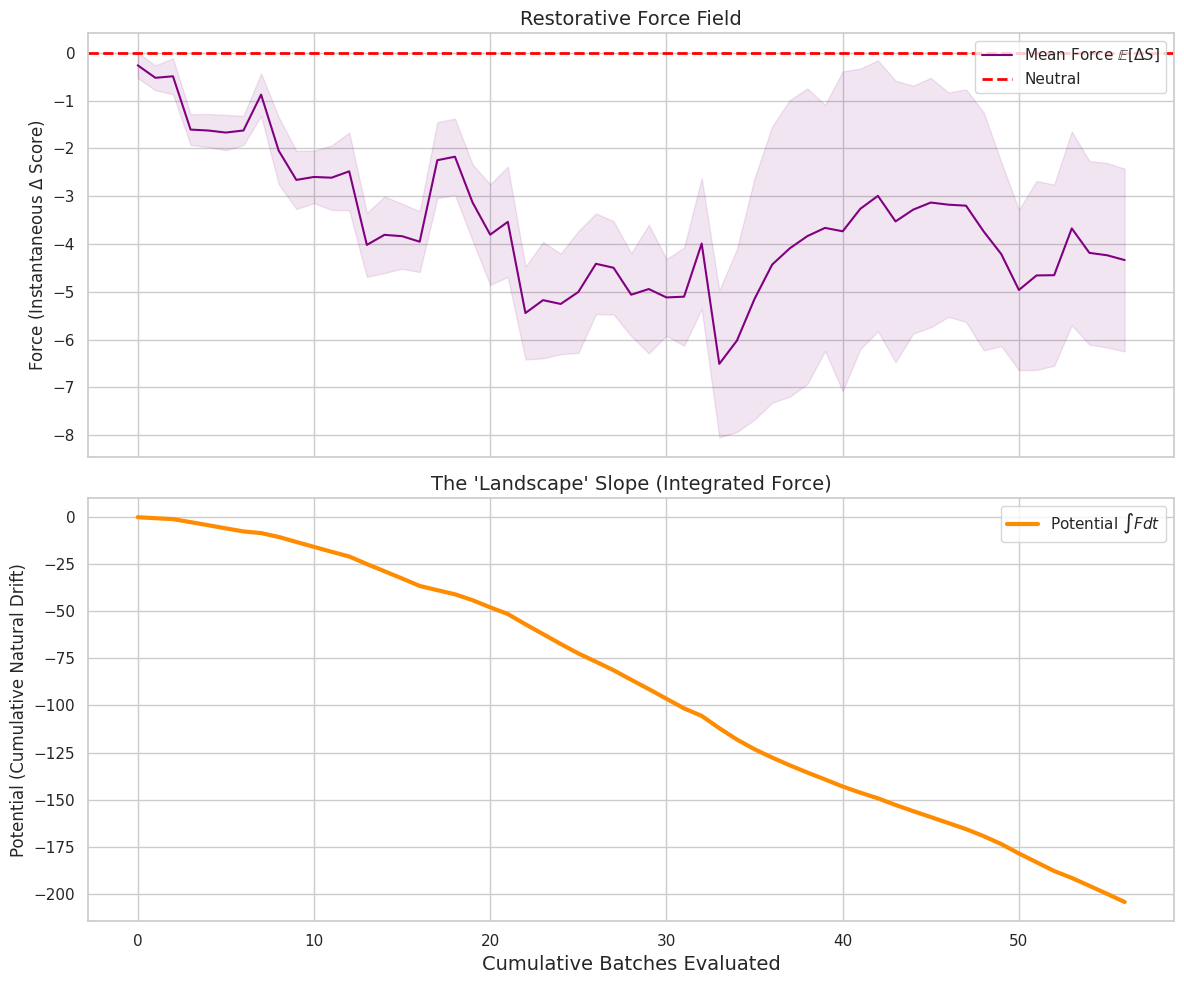

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

# --- CONFIGURATION ---
RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/steering_meta_v2/ILSVRC2012_val_00000729/meta_cat/noise_100_p1.0"
DATA_FILE = os.path.join(RESULTS_DIR, "force_stats.npz")
STEERING_FILE = os.path.join(RESULTS_DIR, "steering_data.npz")

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError("Data not found.")

# Load Data
force_data = np.load(DATA_FILE)
force_history = force_data['force'] # [Mean, Std] per batch

steering_data = np.load(STEERING_FILE)
attempts_per_step = steering_data['attempts']

# --- CALCULATE POTENTIAL (Integration) ---
# Potential = Cumulative Sum of the Mean Force
# This represents the "Natural Drift" of the system.
# If this goes down, the diffusion model naturally wants to destroy the target class.
potential = np.cumsum(force_history[:, 0])

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 1. FORCE PLOT (Instantaneous)
means = force_history[:, 0]
stds = force_history[:, 1]
batch_indices = np.arange(len(means))

ax1.plot(batch_indices, means, color='purple', label="Mean Force $\mathbb{E}[\Delta S]$", linewidth=1.5)
ax1.fill_between(batch_indices, means - stds, means + stds, color='purple', alpha=0.1)
ax1.axhline(0, color='red', linestyle='--', linewidth=2, label="Neutral")
ax1.set_ylabel("Force (Instantaneous $\Delta$ Score)", fontsize=12)
ax1.set_title("Restorative Force Field", fontsize=14)
ax1.legend(loc="upper right")

# 2. POTENTIAL PLOT (Integrated)
ax2.plot(batch_indices, potential, color='darkorange', linewidth=3, label="Potential $\int F dt$")
ax2.set_ylabel("Potential (Cumulative Natural Drift)", fontsize=12)
ax2.set_xlabel("Cumulative Batches Evaluated", fontsize=14)
ax2.set_title("The 'Landscape' Slope (Integrated Force)", fontsize=14)
ax2.legend(loc="upper right")

# Overlay Step Transitions on both
cumulative = 0
for i, count in enumerate(attempts_per_step):
    if i == 0: continue
    if count == 0: break
    cumulative += count
    if cumulative <= len(means):
        ax1.axvline(cumulative, color='gray', alpha=0.3, linestyle=':')
        ax2.axvline(cumulative, color='gray', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

for infinite cost:
randomly diffuse images (without forcing) and we can look at the meta labels coming from the imagenet tree. we can measure the label vectors along the trajectory and see if we get stuck or not. this is expensive by just randomly diffusing, some observables would relax and some would not. for the ones that never relax steering should be hard (or impossible) etc.

for finite cost and time:
we can restrict to a class - let's say dogs, since they have their own subclasses?
could we use the diffusion process to define another tree instead of the imagenet? could we do at least a sub tree?
the idea is to either check tree distances or to look at transition probabilities
we can check the imagenet tree - if the meta labels all decorrelate at the same rate this means the imagenet tree is bullshit, let's see.



1) repeat this process without steering, meta labels
2) find easy places to diffuse, there you can steer more easily
3) track the vector field of the force (look at all the probabilities - save them, then we can define all the possible forces between classes)
4) talk to hyunmo about the decorrelation of latents for the rhm
5) 

✅ Loaded ImageNet labels.
✅ Loaded data shape: (50, 201, 1000)
  - 50 Trajectories
  - 201 Steps per trajectory

--- Top 10 'Downhill' Classes (Easiest to Steer To) ---
1. wombat (Idx 106): Force = +0.5424
2. Italian Greyhound (Idx 171): Force = +0.5267
3. borzoi (Idx 169): Force = +0.4810
4. wing (Idx 908): Force = +0.4662
5. Norwegian Elkhound (Idx 174): Force = +0.4626
6. hay (Idx 958): Force = +0.4462
7. Kuvasz (Idx 222): Force = +0.4334
8. Cocker Spaniels (Idx 219): Force = +0.4306
9. binoculars (Idx 447): Force = +0.4169
10. Chihuahua (Idx 151): Force = +0.4164

--- Top 10 'Uphill' Classes (Hardest to Steer To) ---
1. Alaskan Malamute (Idx 249): Force = -0.9424
2. jeep (Idx 609): Force = -0.7341
3. loggerhead sea turtle (Idx 33): Force = -0.5828
4. dingo (Idx 273): Force = -0.4926
5. grey wolf (Idx 269): Force = -0.4813
6. kit fox (Idx 278): Force = -0.4599
7. Tibetan Mastiff (Idx 244): Force = -0.4582
8. jaguar (Idx 290): Force = -0.4511
9. Rhodesian Ridgeback (Idx 159): Force =

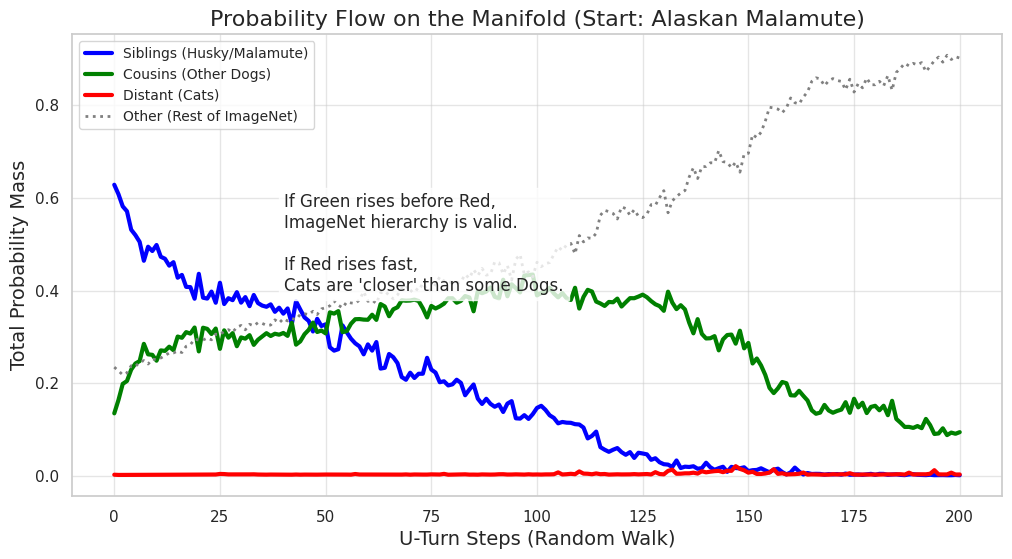

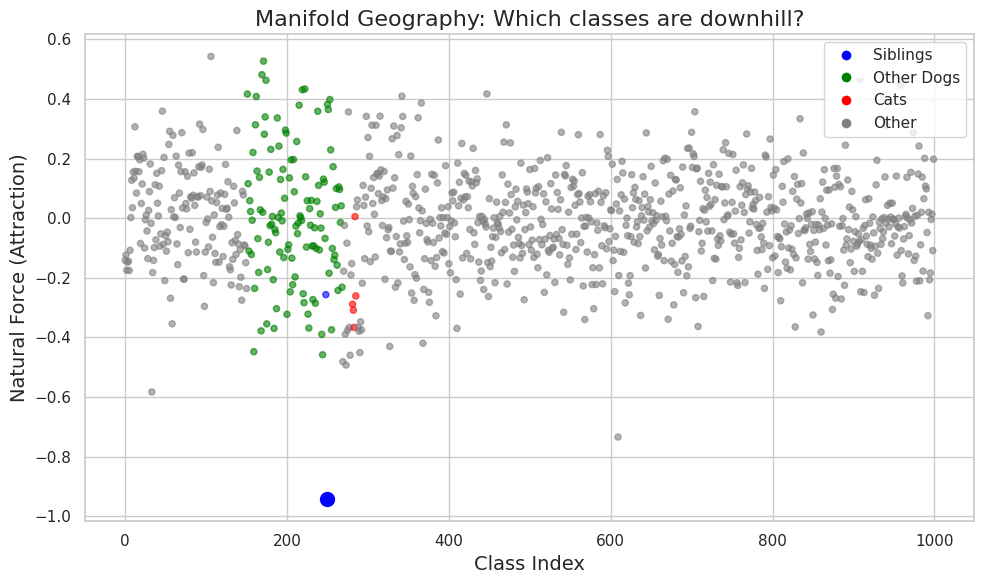

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import json
import urllib.request
from scipy.stats import sem

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# --- CONFIGURATION ---
# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_100"
RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_50"
# RESULTS_DIR = "/work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_40"
ORIG_CLASS_IDX = 249  # Malamute (Based on your classifier's prediction) / 250 (Husky)

# --- 1. LOAD CLASS LABELS ---
# We need names to make sense of the 1000 indices
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
try:
    class_labels = json.loads(urllib.request.urlopen(url).read().decode())
    print("✅ Loaded ImageNet labels.")
except:
    print("⚠️ Could not load labels, using indices.")
    class_labels = [str(i) for i in range(1000)]

# --- 2. LOAD TRAJECTORY DATA ---
# We want to stack them into a tensor: [Trajectories, Steps, Classes]
traj_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "traj_*", "manifold_logits.npz")))

if not traj_files:
    raise FileNotFoundError(f"No data found in {RESULTS_DIR}")

all_logits = []
for f in traj_files:
    data = np.load(f)['logits'] # Shape: [201, 1000]
    all_logits.append(data)

# Stack: [N_traj, N_steps, 1000]
logits_tensor = np.stack(all_logits)
num_traj, num_steps, num_classes = logits_tensor.shape

print(f"✅ Loaded data shape: {logits_tensor.shape}")
print(f"  - {num_traj} Trajectories")
print(f"  - {num_steps} Steps per trajectory")

# Convert logits to probabilities for visualization
# (We do this numerically stably)
# Softmax over axis 2
exp_logits = np.exp(logits_tensor - np.max(logits_tensor, axis=2, keepdims=True))
probs_tensor = exp_logits / np.sum(exp_logits, axis=2, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS A: The "Natural Force" Vector Field
# ---------------------------------------------------------
# We measure the average change in logit for every class over the first few steps.
# This tells us which direction is "Downhill".
# Force_c = Mean( Logit_c(t=1) - Logit_c(t=0) ) over all trajectories

steps_to_avg = 10 # Look at immediate drift
initial_logits = logits_tensor[:, 0, :]        # [N_traj, 1000]
future_logits = logits_tensor[:, steps_to_avg, :] # [N_traj, 1000]

delta_logits = future_logits - initial_logits
mean_force = np.mean(delta_logits, axis=0) # [1000] vector of forces

# Sort classes by Force (Most attractive to Least attractive)
sorted_indices = np.argsort(mean_force)[::-1] # Descending

print(f"\n--- Top 10 'Downhill' Classes (Easiest to Steer To) ---")
for i in range(10):
    idx = sorted_indices[i]
    print(f"{i+1}. {class_labels[idx]} (Idx {idx}): Force = +{mean_force[idx]:.4f}")

print(f"\n--- Top 10 'Uphill' Classes (Hardest to Steer To) ---")
for i in range(10):
    idx = sorted_indices[-(i+1)]
    print(f"{i+1}. {class_labels[idx]} (Idx {idx}): Force = {mean_force[idx]:.4f}")

# ---------------------------------------------------------
# ANALYSIS B: Validating the Hierarchy
# ---------------------------------------------------------
# We define sets of classes based on distance from the original
# (Approximate groups based on ImageNet structure)

GROUP_SIBLINGS = [248, 249]#, 250] # Eskimo Dog, Malamute, Husky
GROUP_COUSINS = list(range(151, 269)) # All Dogs (excluding siblings)
# Remove siblings from cousins for cleaner plot
GROUP_COUSINS = [i for i in GROUP_COUSINS if i not in GROUP_SIBLINGS]
GROUP_DISTANT = list(range(281, 286)) # Cats

# Calculate Total Probability Mass for each group over time
# Mean over trajectories [Steps]
mass_self = np.mean(np.sum(probs_tensor[:, :, GROUP_SIBLINGS], axis=2), axis=0)
mass_cousins = np.mean(np.sum(probs_tensor[:, :, GROUP_COUSINS], axis=2), axis=0)
mass_distant = np.mean(np.sum(probs_tensor[:, :, GROUP_DISTANT], axis=2), axis=0)
# Everything else
mass_other = 1.0 - (mass_self + mass_cousins + mass_distant)

# --- Plotting ---
plt.figure(figsize=(12, 6))
x = np.arange(num_steps)

plt.plot(x, mass_self, label="Siblings (Husky/Malamute)", linewidth=3, color='blue')
plt.plot(x, mass_cousins, label="Cousins (Other Dogs)", linewidth=3, color='green')
plt.plot(x, mass_distant, label="Distant (Cats)", linewidth=3, color='red')
plt.plot(x, mass_other, label="Other (Rest of ImageNet)", linewidth=2, color='gray', linestyle=':')

plt.xlabel("U-Turn Steps (Random Walk)", fontsize=14)
plt.ylabel("Total Probability Mass", fontsize=14)
plt.title(f"Probability Flow on the Manifold (Start: {class_labels[ORIG_CLASS_IDX]})", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)

# Add interpretation text
plt.text(num_steps*0.2, 0.4, 
         "If Green rises before Red,\nImageNet hierarchy is valid.\n\nIf Red rises fast,\nCats are 'closer' than some Dogs.", 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# ---------------------------------------------------------
# ANALYSIS C: Force vs. Semantic Distance
# ---------------------------------------------------------
# We create a scatter plot.
# X-Axis: "Semantic Distance" (We approximate this by checking if it's a dog or not)
# Y-Axis: The "Natural Force" we calculated earlier

is_dog = np.zeros(1000)
is_dog[151:269] = 1 # Mark all dogs
is_dog[GROUP_SIBLINGS] = 2 # Mark siblings

colors = np.array(['gray'] * 1000, dtype=object)
colors[is_dog == 1] = 'green' # Dogs
colors[is_dog == 2] = 'blue'  # Siblings
colors[281:286] = 'red'       # Cats

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(1000), mean_force, c=colors, alpha=0.6, s=20)

# Highlight specific points
plt.scatter(ORIG_CLASS_IDX, mean_force[ORIG_CLASS_IDX], c='blue', s=100, label="Start Class")

plt.xlabel("Class Index", fontsize=14)
plt.ylabel("Natural Force (Attraction)", fontsize=14)
plt.title("Manifold Geography: Which classes are downhill?", fontsize=16)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Siblings', markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Other Dogs', markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Cats', markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='gray', markersize=8)]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Visualizing Trajectory: /work/pcsl/Noam/sequential_diffusion/results/manifold_probe/ILSVRC2012_val_00000729/probe_noise_50/traj_000


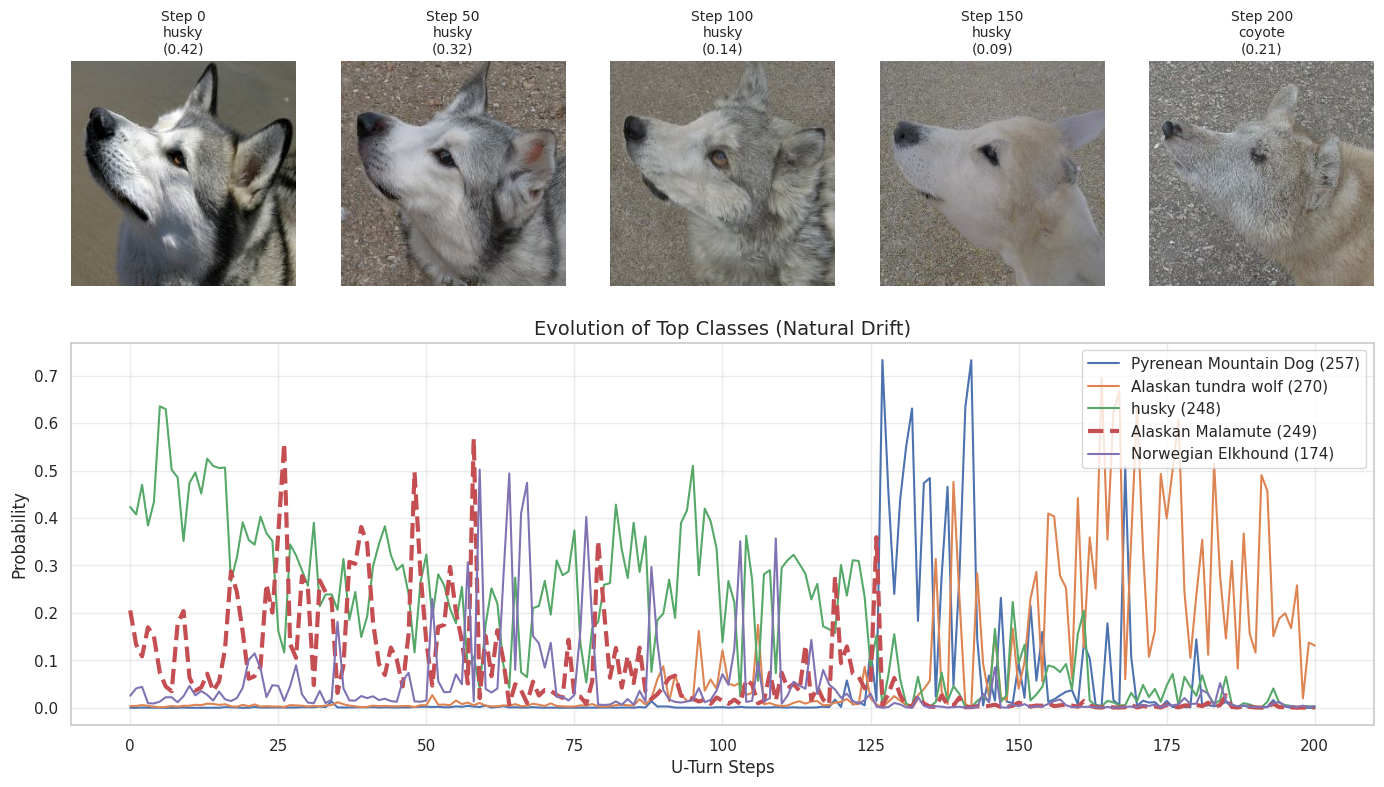

In [167]:
# ---------------------------------------------------------
# ANALYSIS D: Single Trajectory Visualization
# ---------------------------------------------------------
TRAJ_IDX_TO_PLOT = 0  # Pick one of the 50 trajectories to look at
TRAJ_DIR = os.path.dirname(traj_files[TRAJ_IDX_TO_PLOT])

print(f"Visualizing Trajectory: {TRAJ_DIR}")

# 1. Load Data for THIS trajectory
single_logits = np.load(os.path.join(TRAJ_DIR, "manifold_logits.npz"))['logits']
# Softmax
single_probs = np.exp(single_logits - np.max(single_logits, axis=1, keepdims=True))
single_probs /= np.sum(single_probs, axis=1, keepdims=True)

# 2. Identify Top Classes to Plot
# We find the classes that had the highest probability at ANY point in the run
max_probs = np.max(single_probs, axis=0)
top_5_indices = np.argsort(max_probs)[::-1][:5] # Top 5 classes

# 3. Visualization
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[0.4, 0.6])

# --- Top Row: Images ---
milestones = [0, 50, 100, 150, 200] # np.arange(0,50,10)#

valid_milestones = [m for m in milestones if m < single_probs.shape[0]]

ax_img = fig.add_subplot(gs[0])
ax_img.axis('off')
sub_gs = gs[0].subgridspec(1, len(valid_milestones))

for i, step in enumerate(valid_milestones):
    ax = fig.add_subplot(sub_gs[i])
    img_path = os.path.join(TRAJ_DIR, f"step_{step:03d}.jpeg")
    
    if os.path.exists(img_path):
        ax.imshow(Image.open(img_path))
    else:
        ax.text(0.5, 0.5, "Missing", ha='center')
        
    # Get top class at this specific moment
    curr_top = np.argmax(single_probs[step])
    prob = single_probs[step, curr_top]
    label = class_labels[curr_top].split(',')[0] # Shorten name
    
    ax.set_title(f"Step {step}\n{label}\n({prob:.2f})", fontsize=10)
    ax.axis('off')

# --- Bottom Row: Probabilities ---
ax_plot = fig.add_subplot(gs[1])

x = np.arange(single_probs.shape[0])

for idx in top_5_indices:
    label = class_labels[idx].split(',')[0]
    linewidth = 3 if idx == ORIG_CLASS_IDX else 1.5
    linestyle = '--' if idx == ORIG_CLASS_IDX else '-'
    
    ax_plot.plot(x, single_probs[:, idx], label=f"{label} ({idx})", linewidth=linewidth, linestyle=linestyle)

ax_plot.set_xlabel("U-Turn Steps", fontsize=12)
ax_plot.set_ylabel("Probability", fontsize=12)
ax_plot.set_title("Evolution of Top Classes (Natural Drift)", fontsize=14)
ax_plot.legend(loc='upper right')
ax_plot.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------------------------
# ANALYSIS B (REVISED): Hierarchical Semantic Drift
# ---------------------------------------------------------

# 1. Define the Semantic Hierarchy (Nested Clusters)
# Indices are based on standard ImageNet-1k
hierarchy = {
    # Level 0: The specific starting identity
    "Sled Dogs (Husky/Malamute)": [248, 249, 250], # Eskimo Dog, Malamute, Siberian Husky
    
    # Level 1: Closest Relatives (Sled & Spitz types)
    # Includes Samoyed, Keeshond, Chow, etc. + Self
    "Cousin Working Dogs": [242, 243, 249, 250, 248, 246 ,247], 
    
    # Level 2: Wild Relatives (Wolves, Foxes)
    # Often diffusion drifts here from Husky
    "Wild Canids (Wolves/Foxes)": list(range(269, 281)), 
    
    # Level 3: The Super-Category
    # All Domestic Dogs (Chihuahua to Mexican Hairless)
    "All Domestic Dogs": list(range(151, 269)),
    
    # Level 4: The Counter-Concept (Target)
    "Cats (Domestic)": list(range(281, 286))
}

# ---------------------------------------------------------
# 2. Compute Probability Mass Flow
# ---------------------------------------------------------
plt.figure(figsize=(14, 8))
colors = sns.color_palette("rainbow", n_colors=len(hierarchy)) # distinct colors
# Override Cat color to red for contrast
cat_color = 'tab:red'

for i, (group_name, indices) in enumerate(hierarchy.items()):
    # Sum probability mass for all classes in this group
    # shape: [N_traj, Steps]
    group_mass_trajectory = np.sum(probs_tensor[:, :, indices], axis=2)
    
    # Average over trajectories
    mean_mass = np.mean(group_mass_trajectory, axis=0)
    
    # Standard Error (shade)
    sem_mass = sem(group_mass_trajectory, axis=0)
    
    # Plotting
    c = cat_color if "Cat" in group_name else colors[i]
    lw = 4 if "Self" in group_name else 2.5
    ls = '--' if "Cat" in group_name else '-'
    
    x = np.arange(len(mean_mass))
    plt.plot(x, mean_mass, label=group_name, color=c, linewidth=lw, linestyle=ls)
    plt.fill_between(x, mean_mass - sem_mass, mean_mass + sem_mass, color=c, alpha=0.1)

# ---------------------------------------------------------
# 3. Formatting
# ---------------------------------------------------------
plt.xlabel("U-Turn Steps (Random Walk)", fontsize=14)
plt.ylabel("Total Probability Mass", fontsize=14)
plt.title(f"Diffusion of Semantic Identity (Hierarchical Flow)", fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.4)
plt.ylim(-.05, .85)
plt.xlim(0, len(mean_mass))
# plt.yscale('log')
# Add "Phase" Annotations based on data (Example placement)
plt.text(10, 0.2, "Phase I: Breed Drift\n(Self → Cousins)", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(100, 0.2, "Phase II: Class Decay\n(Dog → Generic Object)", fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()